## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from sklearn.ensemble import (GradientBoostingClassifier,
                              HistGradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm import tqdm

## Dataset

### Dataset loading

In [2]:
df_data = pd.read_csv("../Data/data.csv")
df_data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
len(df_data)

6819

### Dataset Exploration and Feature selection

In [4]:
# Get the data types of all columns
column_types = df_data.dtypes

# Count the number of columns per type
type_summary = column_types.value_counts().reset_index()

# Rename columns for better understanding
type_summary.columns = ["Data Type", "Number of Columns"]

# Display the summary DataFrame
type_summary

,Data Type,Number of Columns
0,float64,93
1,int64,3


Our Dataset is numerical, so we don't have to change the type of any column. 
(if not, we usually use the OneHotencoding or the LabelEncoder)

##### Na values Treatment

In [5]:
nb_NA = df_data.isna().sum().value_counts().index.values[0]
nb_colonne = df_data.isna().sum().value_counts()[0]

print(
    "The number of NA values is:",
    nb_NA,
    "for the",
    nb_colonne,
    "columns.\nIf we had Na values, severals methods could be implemented like impute with mean or median value of the column \nor if we had enough data we could have also remove the row.",
)

The number of NA values is: 0 for the 96 columns.
If we had Na values, severals methods could be implemented like impute with mean or median value of the column 
or if we had enough data we could have also remove the row.


#### Correlation among features

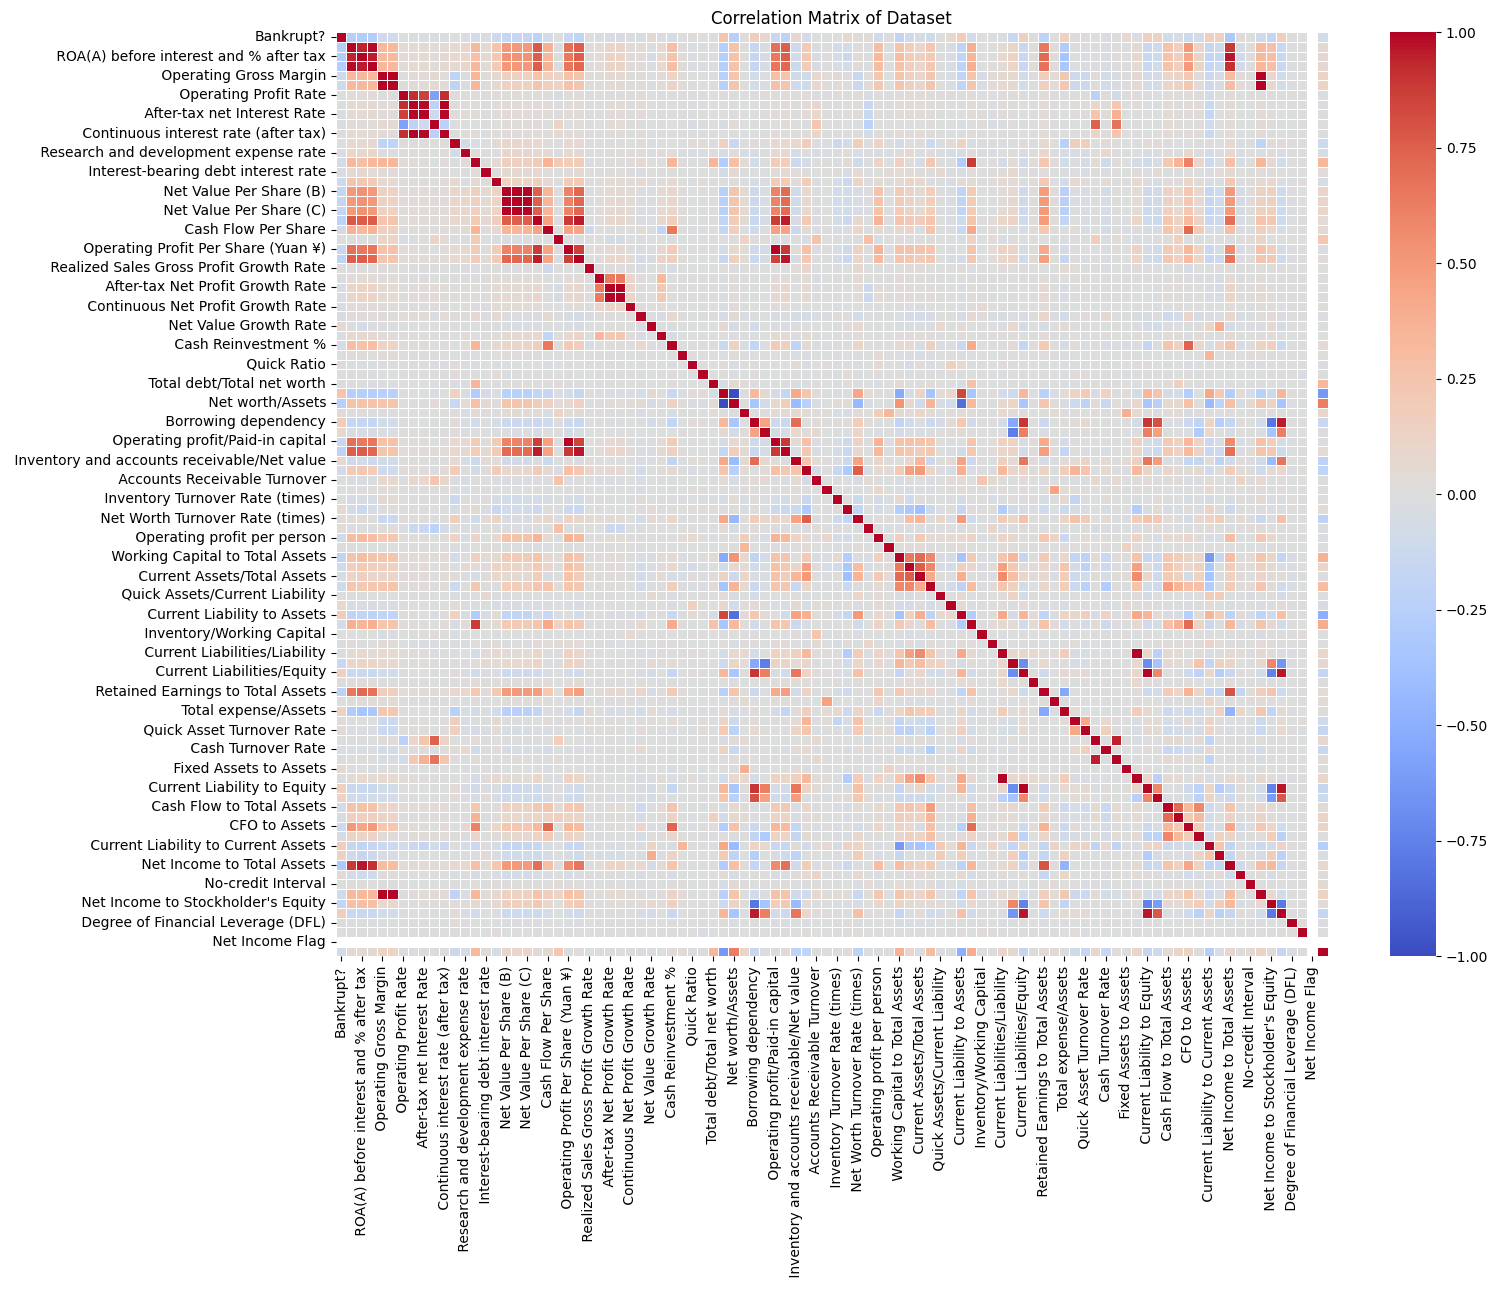

In [6]:
# Check the correlatiton of the different columns
# Calculate the correlation matrix
correlation_matrix = df_data.corr()

# Create a heatmap with seaborn
plt.figure(figsize=(16, 12))  # Adjust the size based on your dataset
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)

# Plot the correlation
plt.title("Correlation Matrix of Dataset")
plt.show()

In [7]:
# We want to show the correlated features
# Compute the correlation matrix
corr_matrix = df_data.corr().abs()  # Using abs() to get the absolute correlation values

# Create a mask to ignore the upper triangle and diagonal of the correlation matrix
upper_tri = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Filter the correlation matrix using the mask and the threshold
high_corr_pairs = corr_matrix.where(upper_tri).stack().reset_index()

# Rename the columns
high_corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]

# Select pairs with correlation above the threshold 0.8
high_corr_pairs_filtered = high_corr_pairs[high_corr_pairs["Correlation"] > 0.8]

# Display the highly correlated pairs
high_corr_pairs_filtered.head()

,Feature 1,Feature 2,Correlation
94,ROA(C) before interest and depreciation befor...,ROA(A) before interest and % after tax,0.940124
95,ROA(C) before interest and depreciation befor...,ROA(B) before interest and depreciation after...,0.986849
178,ROA(C) before interest and depreciation befor...,Net Income to Total Assets,0.887670
187,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after...,0.955741
270,ROA(A) before interest and % after tax,Net Income to Total Assets,0.961552


In [8]:
# Results
print(
    "We have",
    len(high_corr_pairs_filtered["Feature 2"].unique()),
    "highly correlated columns as show in the correlation matrix.\nThese columns could lead to an overfitting in the model prediction this is why it is better to drop these columns from the dataset.",
)

We have 25 highly correlated columns as show in the correlation matrix.
These columns could lead to an overfitting in the model prediction this is why it is better to drop these columns from the dataset.


In [9]:
# Drop one of the highly correlated features, and so we keep the data not correlated in order to train the model
df_data_reduced = df_data.drop(high_corr_pairs_filtered["Feature 2"].unique(), axis=1)
df_data_reduced.shape

(6819, 71)

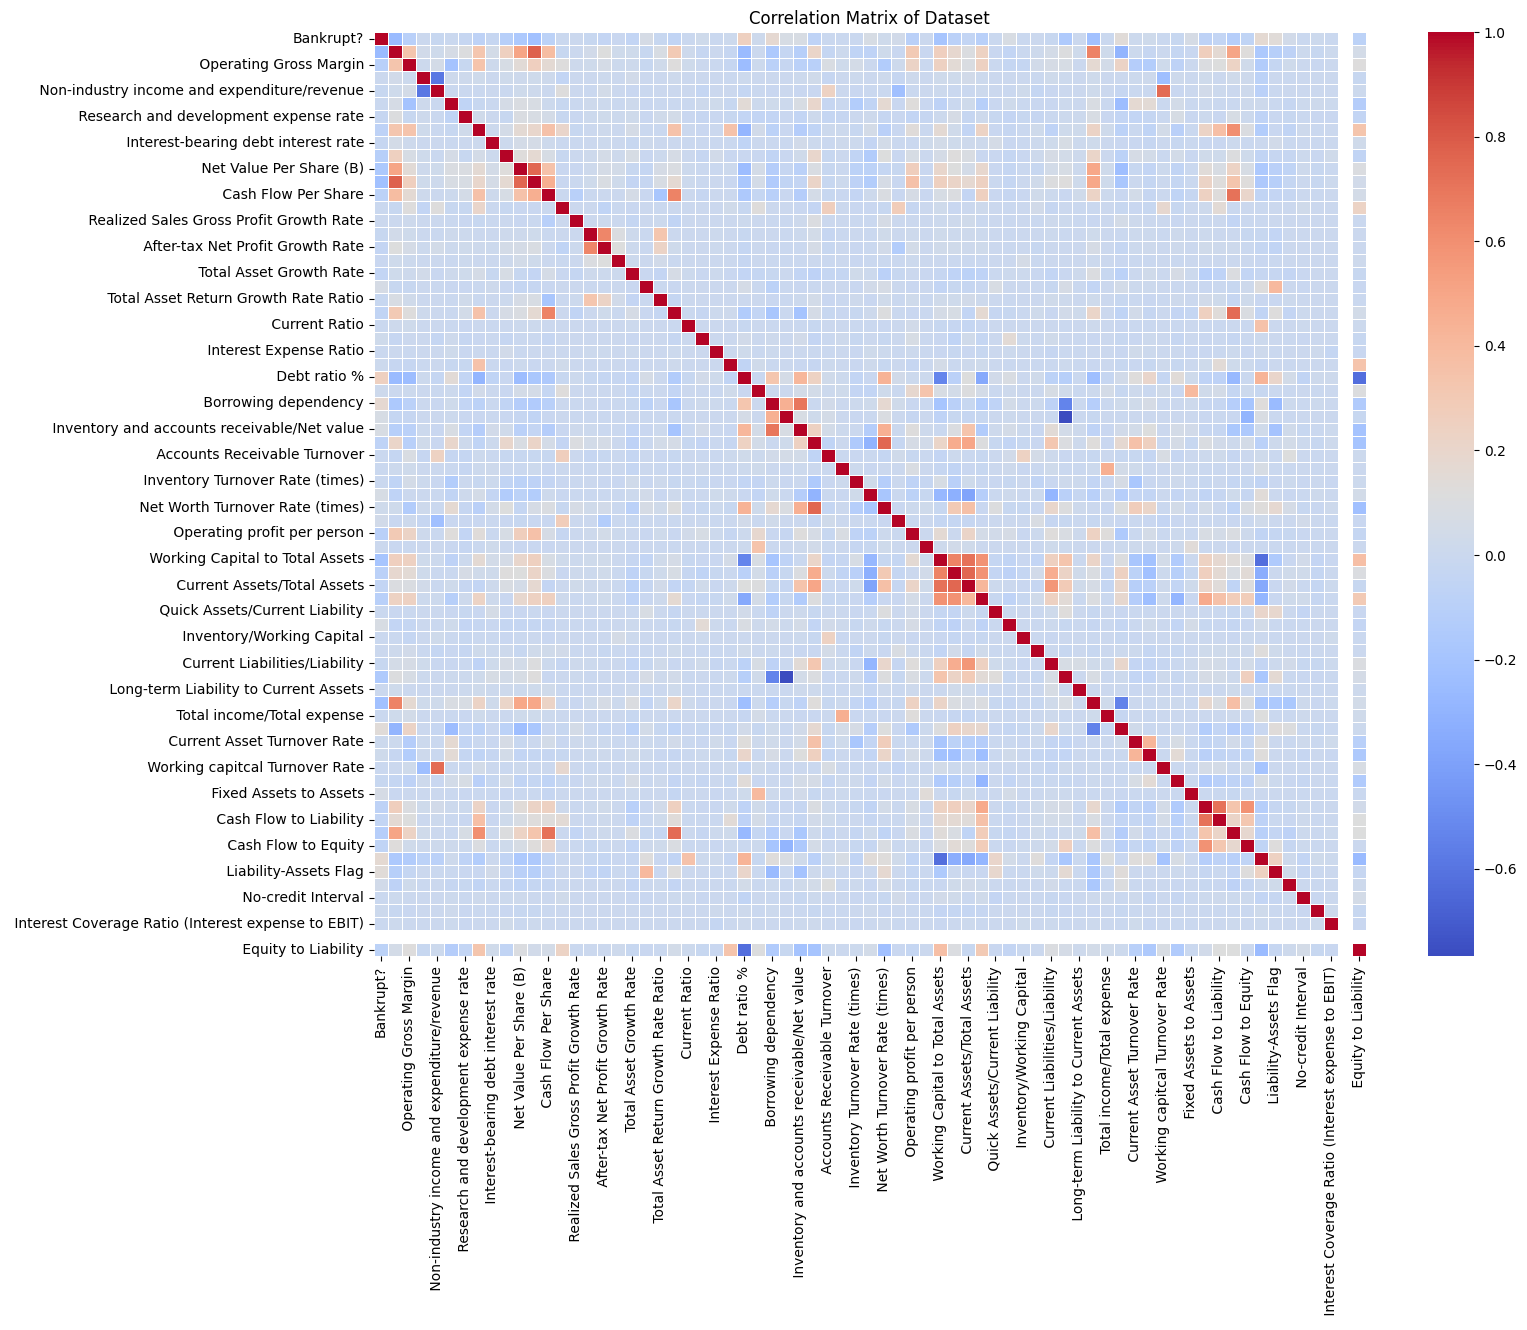

In [10]:
# Check the correlatiton of the different columns
# Calculate the correlation matrix
correlation_matrix_r = df_data_reduced.corr()

# Create a heatmap with seaborn
plt.figure(figsize=(16, 12))  # Adjust the size based on your dataset
sns.heatmap(correlation_matrix_r, annot=False, cmap="coolwarm", linewidths=0.5)

# Plot the correlation of the filtered columns
plt.title("Correlation Matrix of Dataset")
plt.show()

In [11]:
# The remained columns are shown here:
df_data_reduced.columns.tolist()

['Bankrupt?',
 ' ROA(C) before interest and depreciation before interest',
 ' Operating Gross Margin',
 ' Operating Profit Rate',
 ' Non-industry income and expenditure/revenue',
 ' Operating Expense Rate',
 ' Research and development expense rate',
 ' Cash flow rate',
 ' Interest-bearing debt interest rate',
 ' Tax rate (A)',
 ' Net Value Per Share (B)',
 ' Persistent EPS in the Last Four Seasons',
 ' Cash Flow Per Share',
 ' Revenue Per Share (Yuan ¥)',
 ' Realized Sales Gross Profit Growth Rate',
 ' Operating Profit Growth Rate',
 ' After-tax Net Profit Growth Rate',
 ' Continuous Net Profit Growth Rate',
 ' Total Asset Growth Rate',
 ' Net Value Growth Rate',
 ' Total Asset Return Growth Rate Ratio',
 ' Cash Reinvestment %',
 ' Current Ratio',
 ' Quick Ratio',
 ' Interest Expense Ratio',
 ' Total debt/Total net worth',
 ' Debt ratio %',
 ' Long-term fund suitability ratio (A)',
 ' Borrowing dependency',
 ' Contingent liabilities/Net worth',
 ' Inventory and accounts receivable/Net 

### Dataset visualization

In this section, i show the different distribution of the features in function of bankruptcy feature, the feature with a signficant different distribution will contribute more in the decision of the model, Whereas a feature that have the same distribution weather is bankrupt or not will not help the model in discriminating both cases.

In [12]:
df_data_reduced.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Operating Profit Rate,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),...,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Total assets to GNP price,No-credit Interval,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.601457,0.998969,0.302646,1.256969e-04,0.0,0.458143,0.000725,0.0,...,0.520382,0.312905,0.118250,0,0.009219,0.622879,0.026601,0.564050,1,0.016469
1,1,0.464291,0.610235,0.998946,0.303556,2.897851e-04,0.0,0.461867,0.000647,0.0,...,0.567101,0.314163,0.047775,0,0.008323,0.623652,0.264577,0.570175,1,0.020794
2,1,0.426071,0.601450,0.998857,0.302035,2.361297e-04,25500000.0,0.458521,0.000790,0.0,...,0.538491,0.314515,0.025346,0,0.040003,0.623841,0.026555,0.563706,1,0.016474
3,1,0.399844,0.583541,0.998700,0.303350,1.078888e-04,0.0,0.465705,0.000449,0.0,...,0.604105,0.302382,0.067250,0,0.003252,0.622929,0.026697,0.564663,1,0.023982
4,1,0.465022,0.598783,0.998973,0.303475,7.890000e+09,0.0,0.462746,0.000686,0.0,...,0.578469,0.311567,0.047725,0,0.003878,0.623521,0.024752,0.575617,1,0.035490


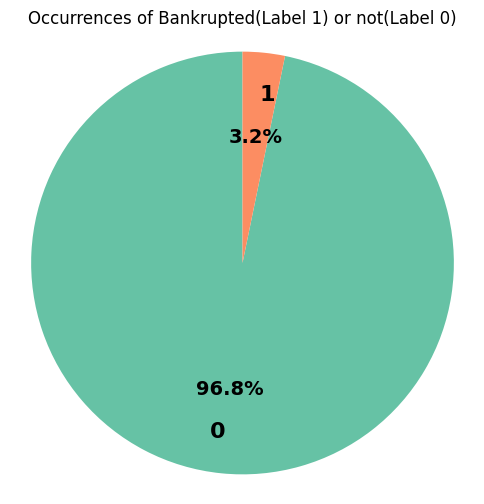

In [43]:
Bkrp_counts = df_data_reduced["Bankrupt?"].value_counts()

# Step 2: Create a DataFrame for easier plotting
Bkrp_counts = Bkrp_counts.reset_index()
Bkrp_counts.columns = ["Bankruptcy", "Count"]

# Step 3: Create a pie chart using Matplotlib
plt.figure(figsize=(6, 6))  # Set figure size

# Create the pie chart
wedges, texts, autotexts = plt.pie(
    Bkrp_counts["Count"], labeldistance=0.8,
    labels = Bkrp_counts["Bankruptcy"],
    autopct="%1.1f%%",
    startangle = 90,
    colors=sns.color_palette("Set2"),  # Format to display percentages
    textprops={'color': 'black'}  # Text color inside slices
)

# Customize the appearance of the labels inside the pie
for text in autotexts:
    text.set_fontsize(14)  # Set font size
    text.set_fontweight('bold')  # Set font weight

# Personnalisation supplémentaire des labels et pourcentages
for text in texts:  # Labels autour du graphique
    text.set_fontsize(16)
    text.set_fontweight('bold')

# Set the aspect ratio to be equal so the pie chart is circular
plt.axis("equal")

# Add a title
plt.title("Occurrences of Bankrupted(Label 1) or not(Label 0)")

# Show the plot
plt.show()

In [25]:
target_column = "Bankrupt?"
# Step 2: Select the feature columns (excluding the target)
feature_columns = df_data_reduced.drop(columns=[target_column]).columns.to_list()

# Step 3: Perform the KS test for each feature and store the results
significant_features = []

for col in feature_columns:
    # Separate the feature values for target = 0 and target = 1
    feature_target_0 = df_data_reduced[df_data_reduced[target_column] == 0][col]
    feature_target_1 = df_data_reduced[df_data_reduced[target_column] == 1][col]

    # Perform KS test
    ks_stat, p_value = ks_2samp(feature_target_0, feature_target_1)

    # Check if the p-value is below the significance threshold, here i selected 0.01, we can check also 0.05
    if p_value < 0.01:
        significant_features.append(col)

# Display the significant features
print(
    len(significant_features),
    "Significant Features where the distributions of Bankruptcy differ :",
)
print(list(significant_features))

similar_dist_features = df_data_reduced.drop(
    columns=significant_features, axis=1
).columns.to_list()
similar_dist_features = [x for x in similar_dist_features if x != "Bankrupt?"]
print(
    "\n",
    len(similar_dist_features),
    "columns that the Bankruptcy distribution dosen" "t differ, the features are:",
)
print(similar_dist_features)

64 Significant Features where the distributions of Bankruptcy differ :
[' ROA(C) before interest and depreciation before interest', ' Operating Gross Margin', ' Operating Profit Rate', ' Non-industry income and expenditure/revenue', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Operating Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Continuous Net Profit Growth Rate', ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Total Asset Return Growth Rate Ratio', ' Cash Reinvestment %', ' Current Ratio', ' Quick Ratio', ' Interest Expense Ratio', ' Total debt/Total net worth', ' Debt ratio %', ' Long-term fund suitability ratio (A)', ' Borrowing dependency', ' Inventory and accounts receivable/Net value', ' Total Asset Turnover', ' A

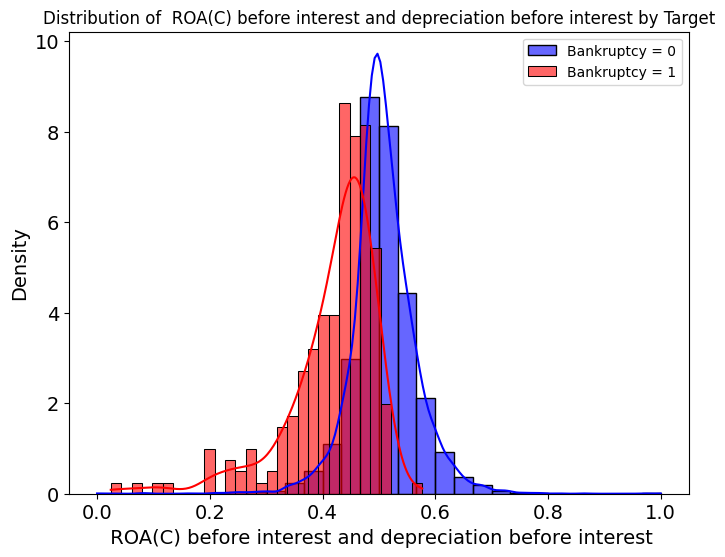

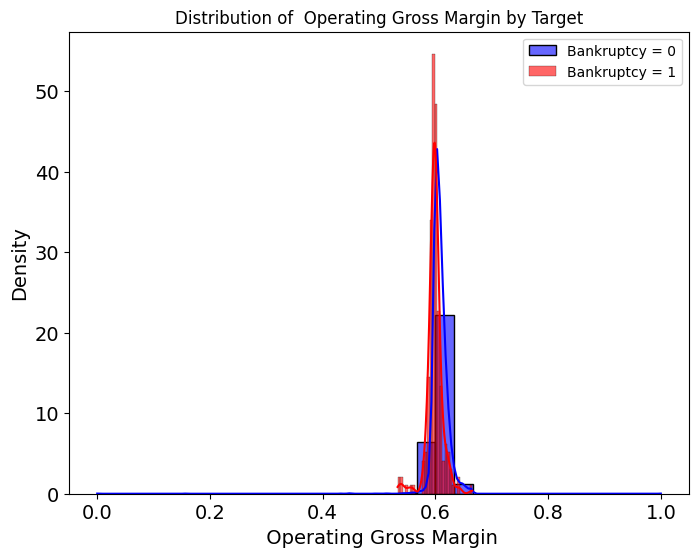

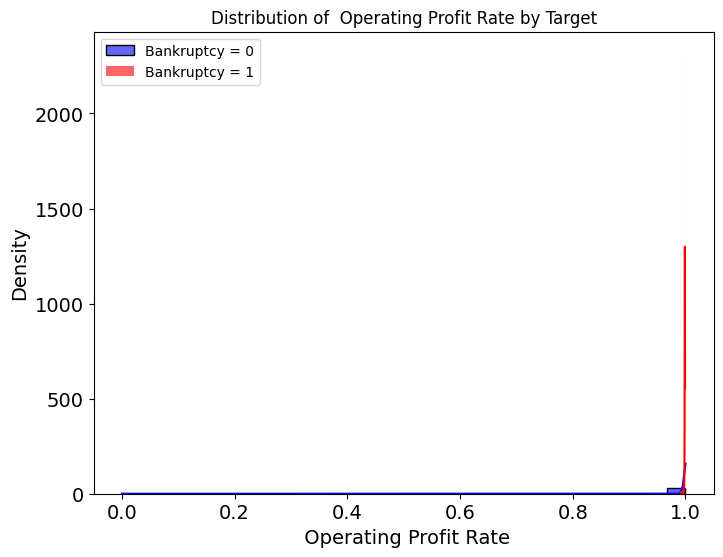

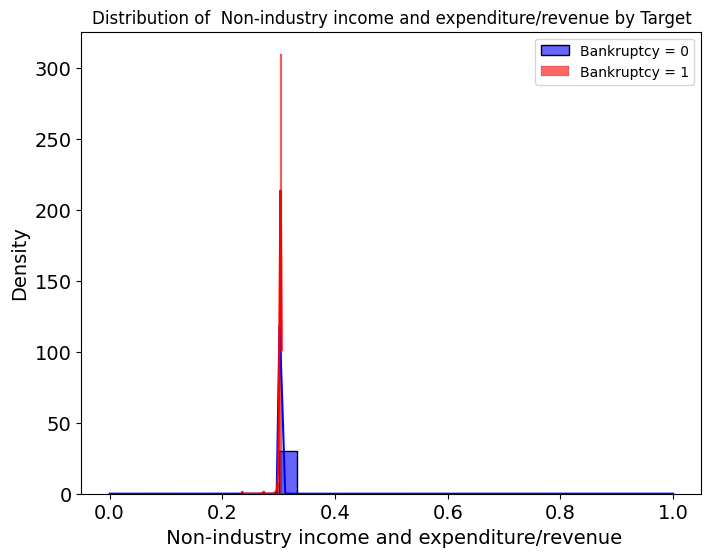

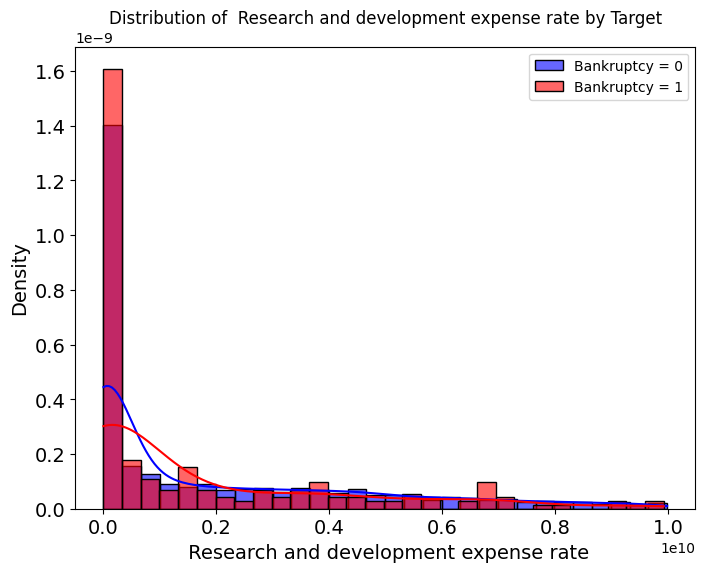

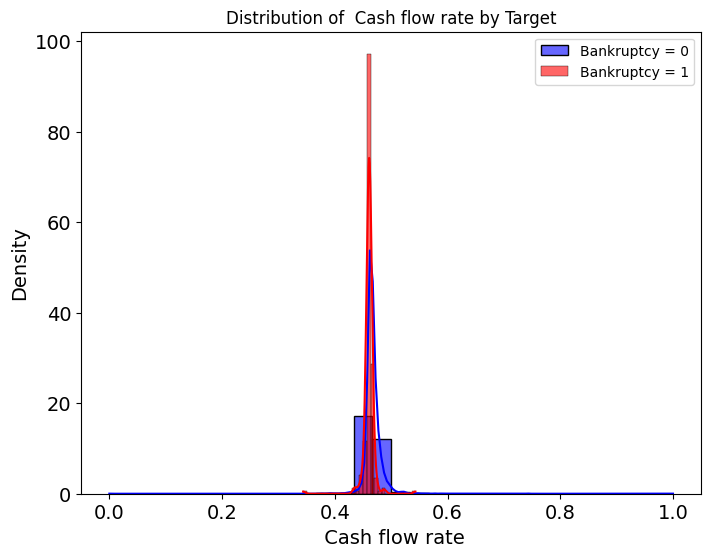

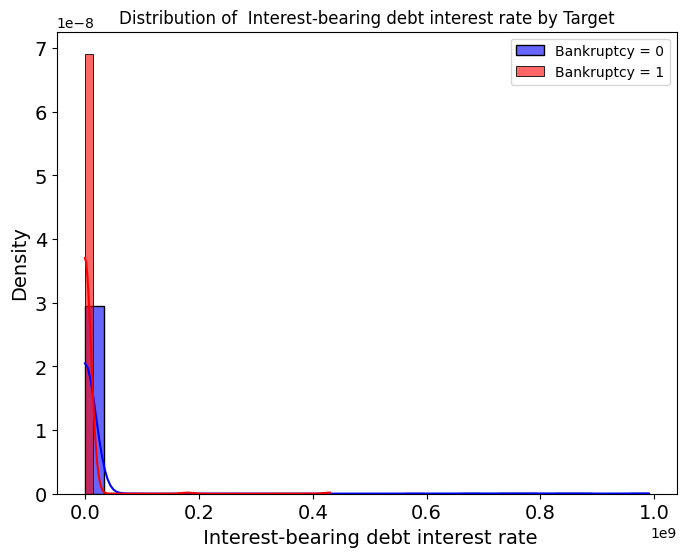

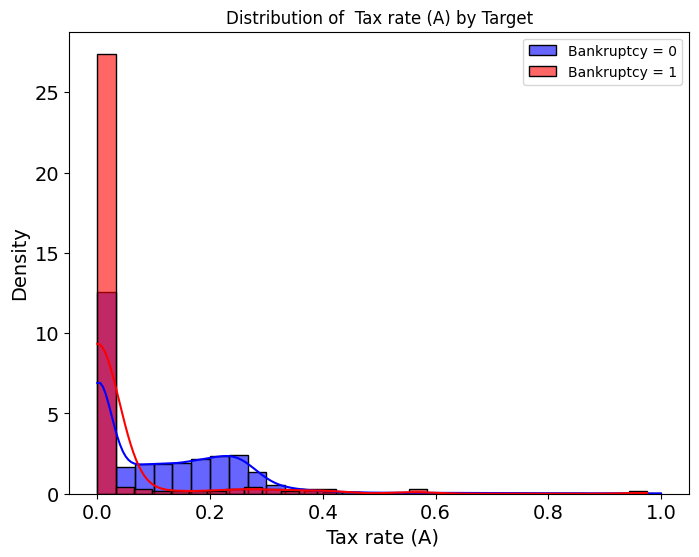

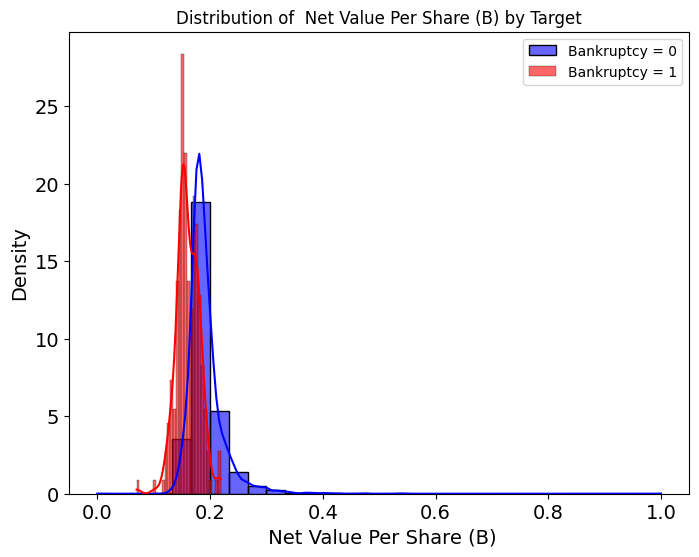

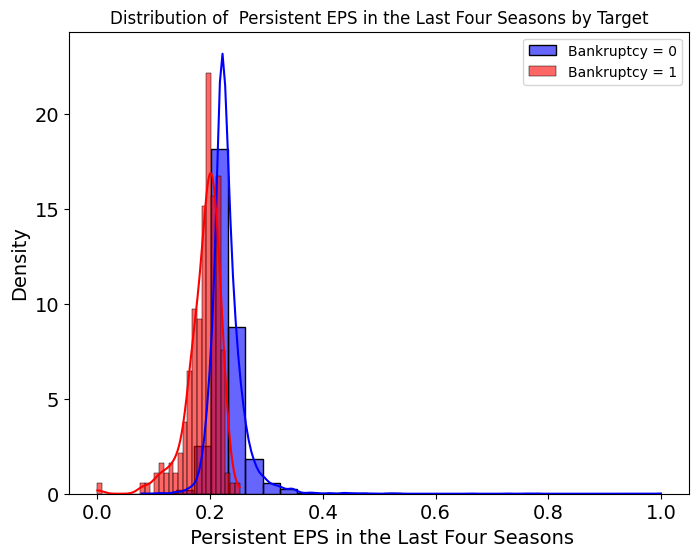

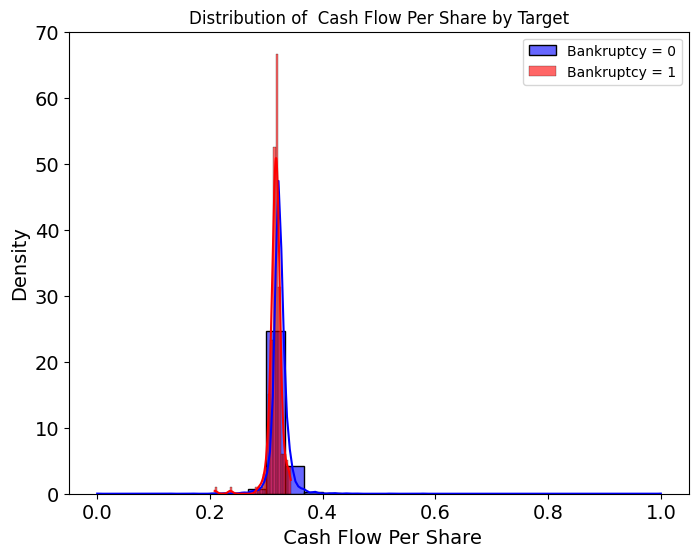

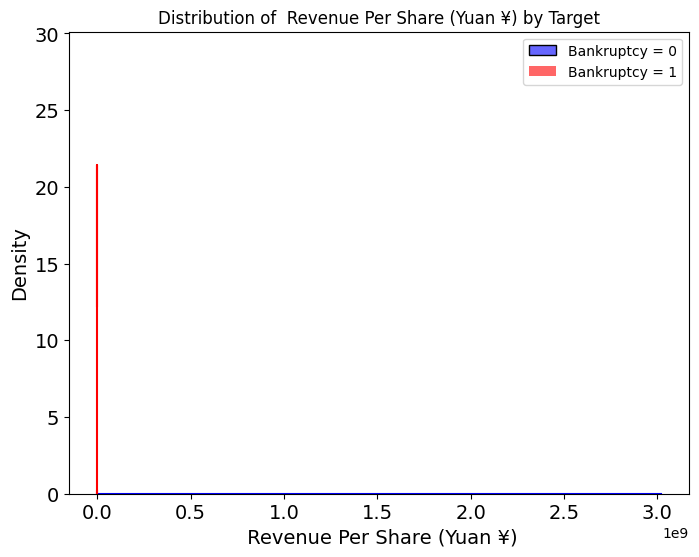

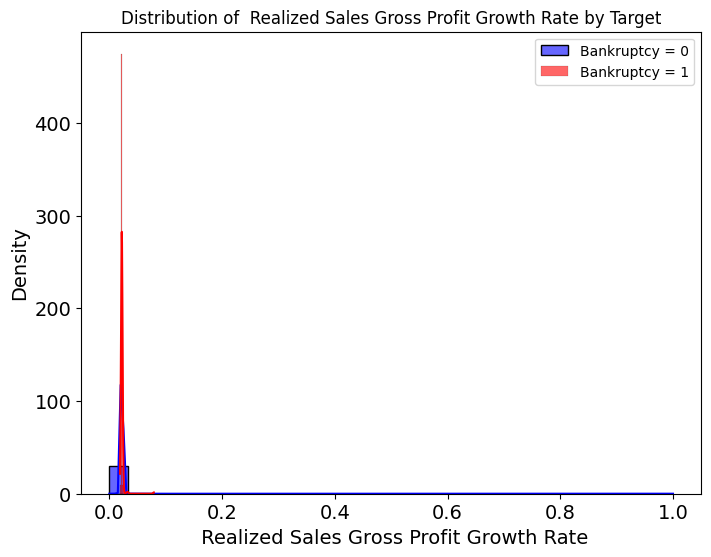

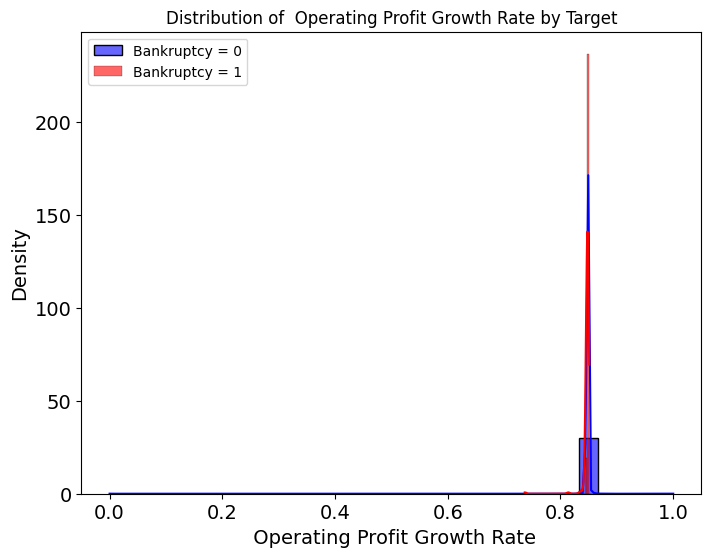

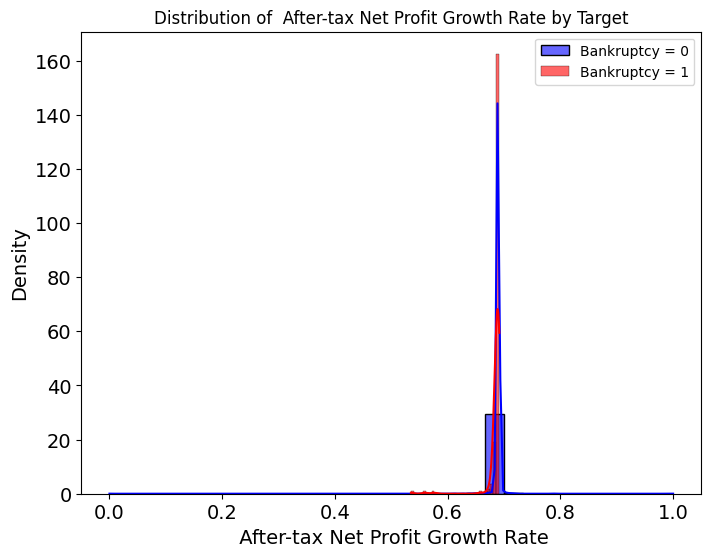

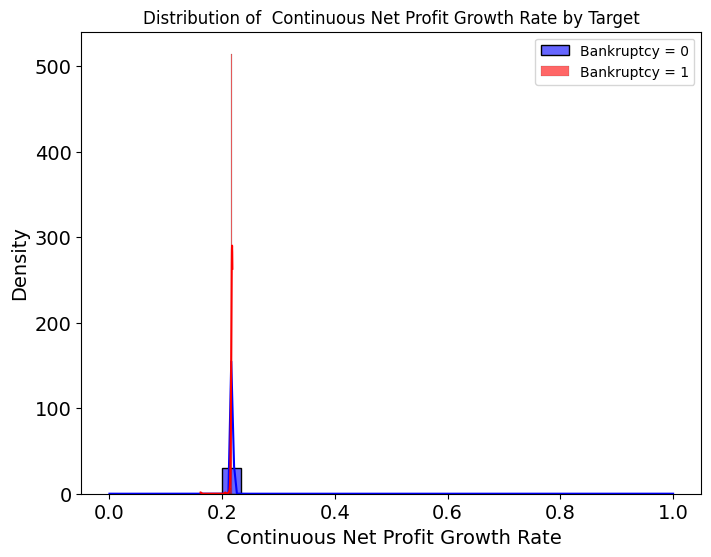

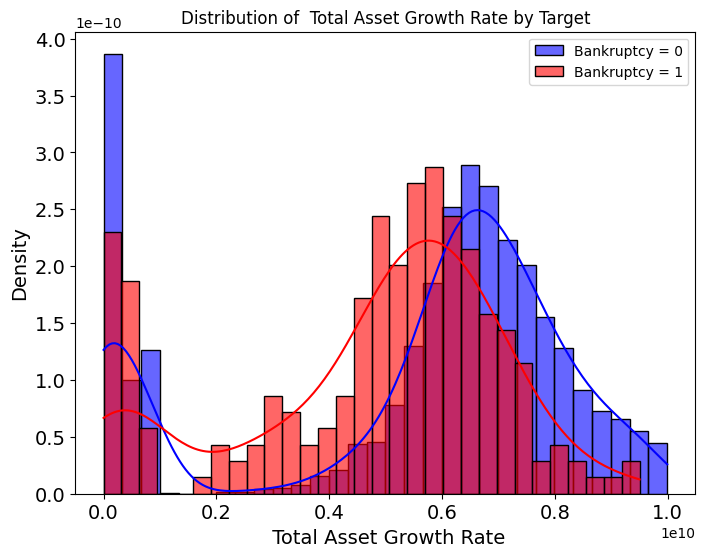

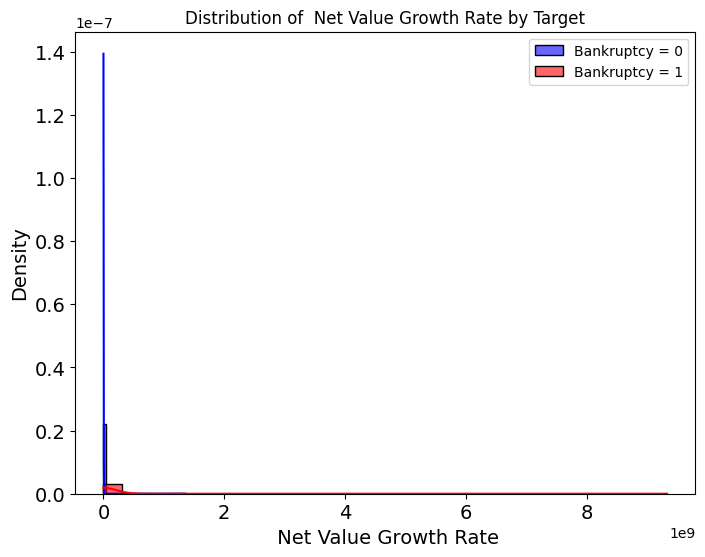

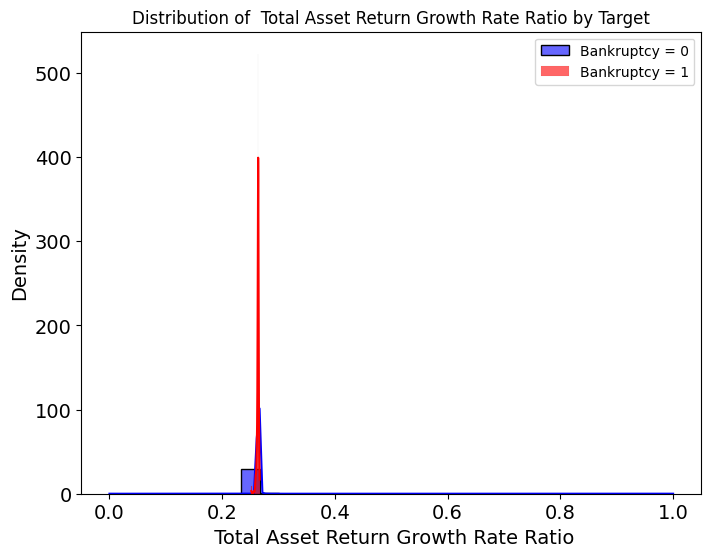

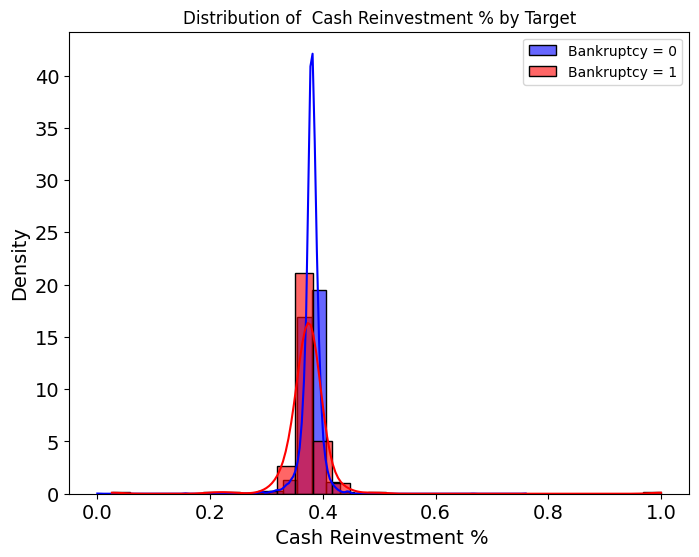

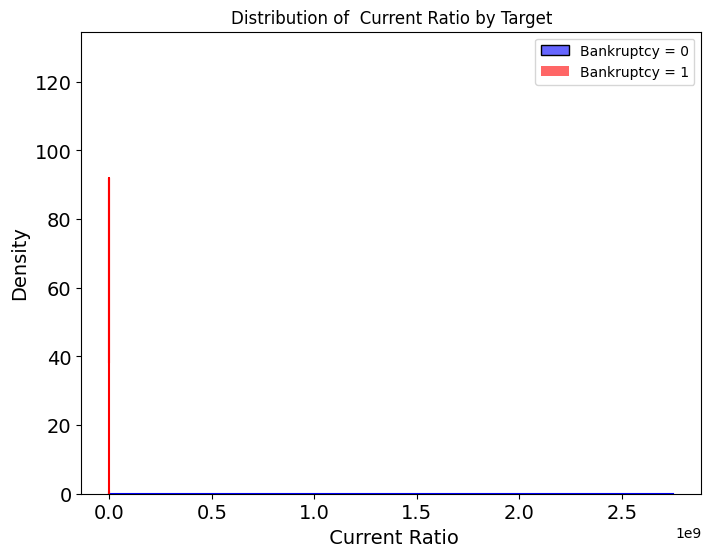

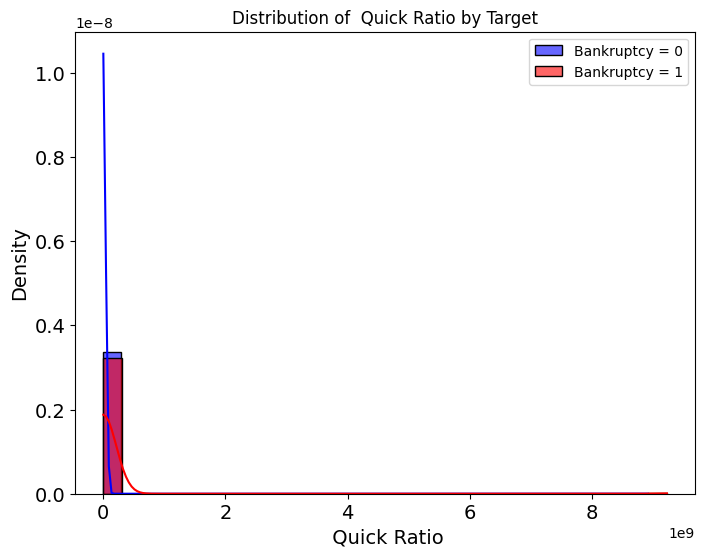

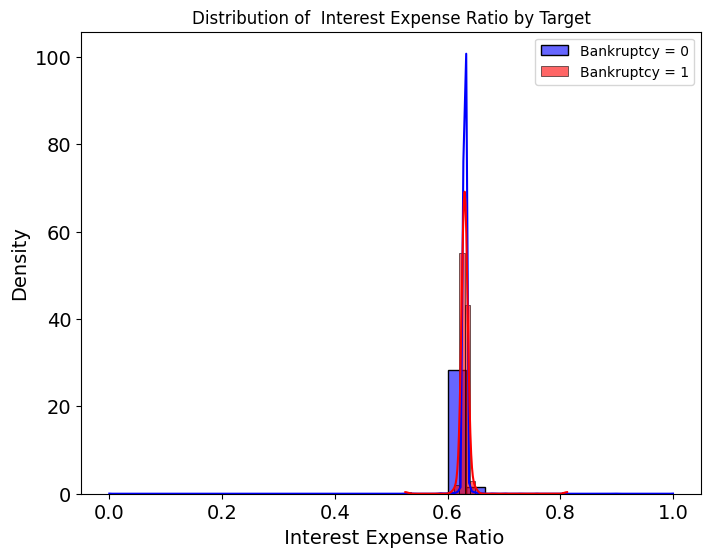

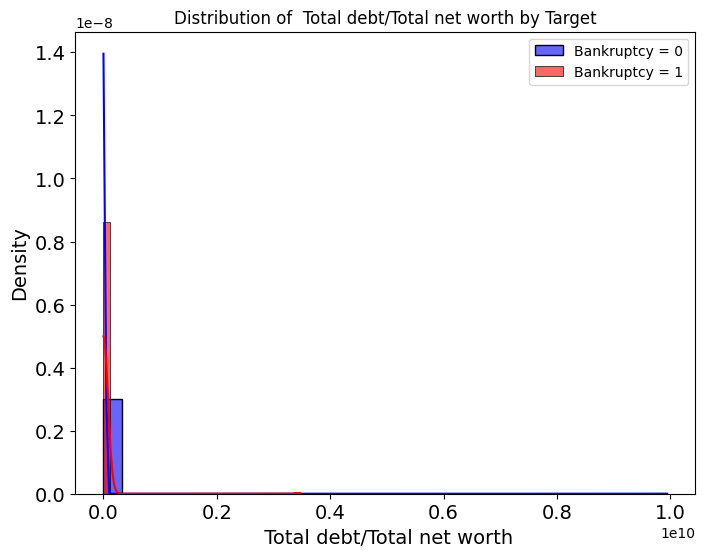

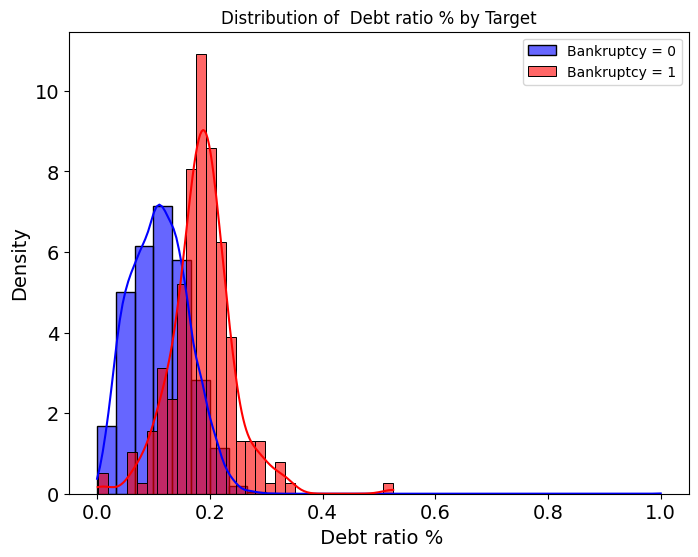

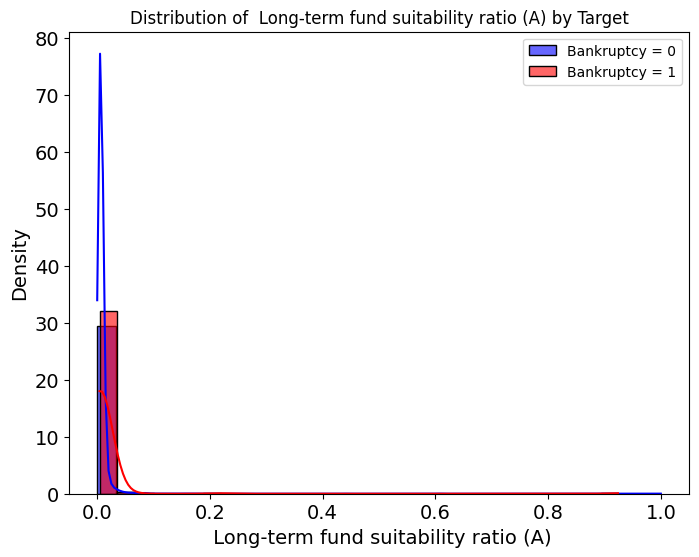

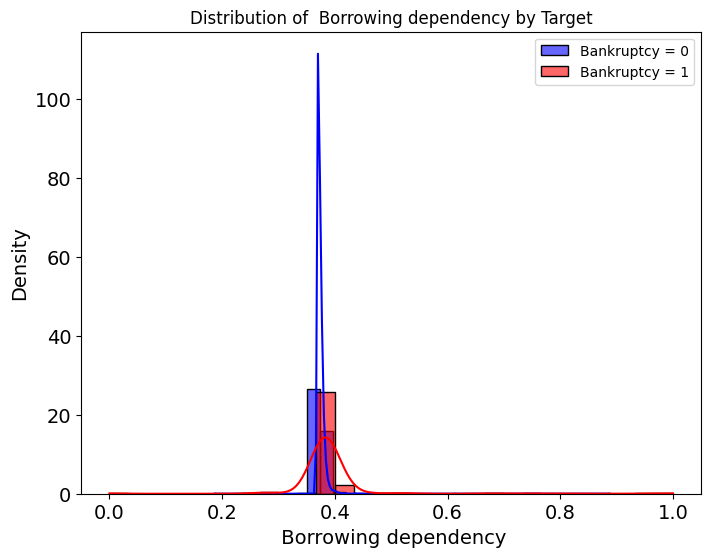

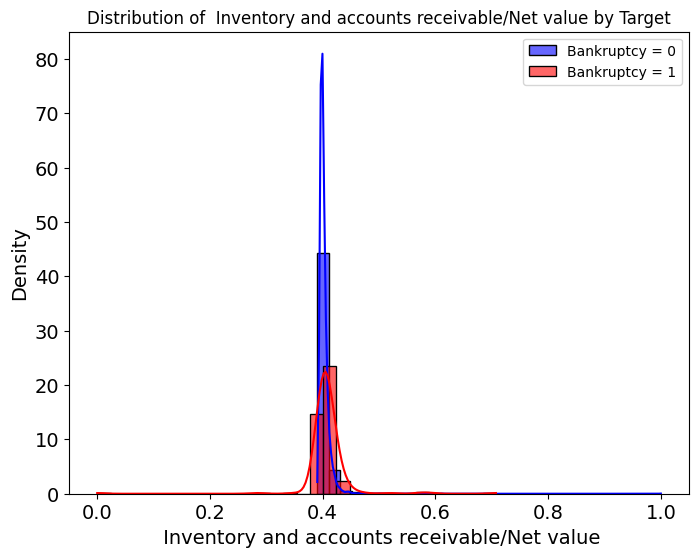

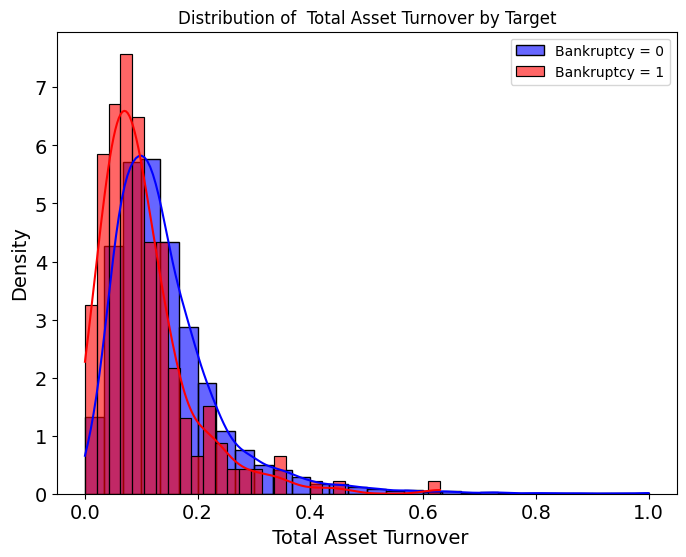

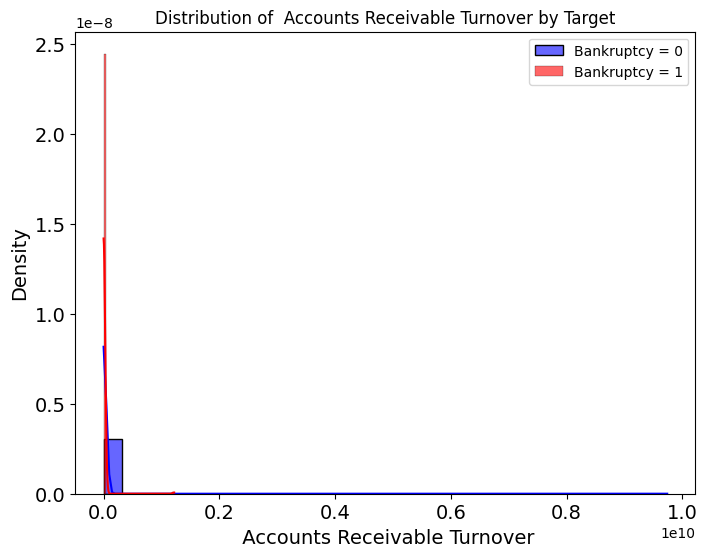

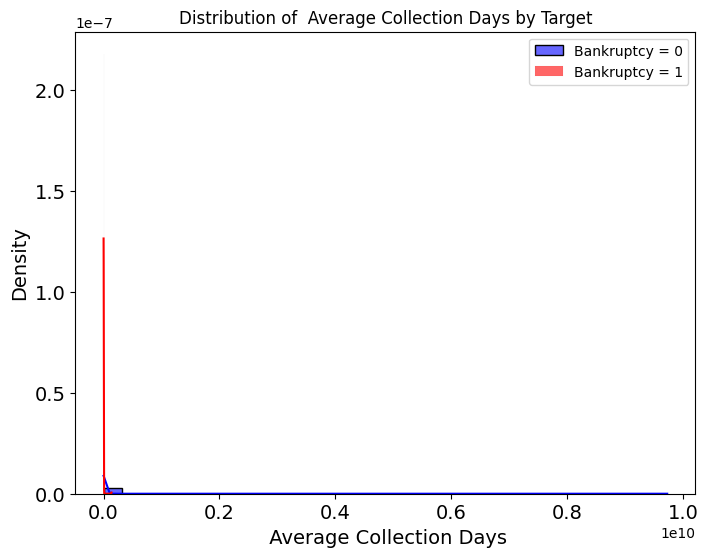

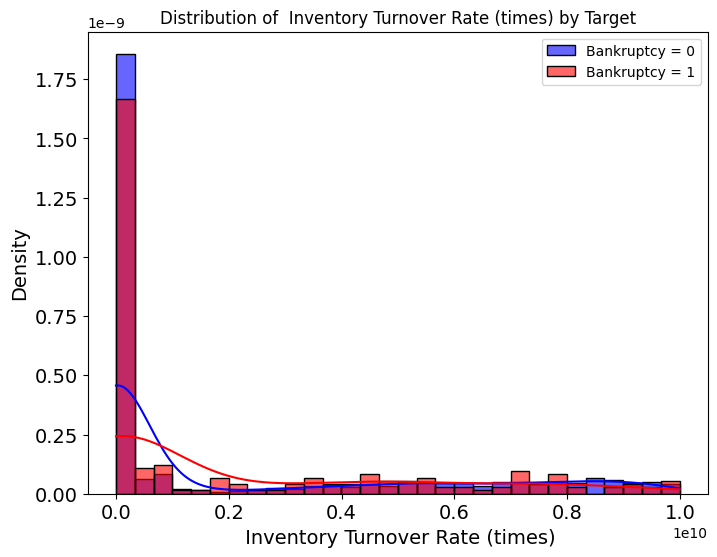

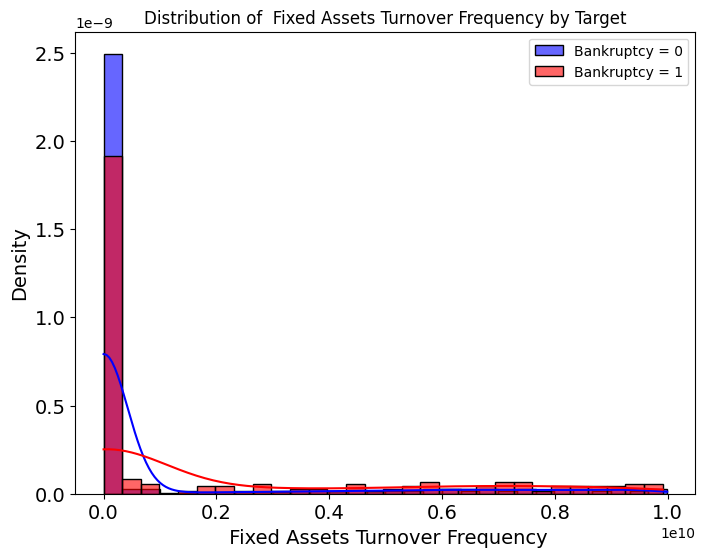

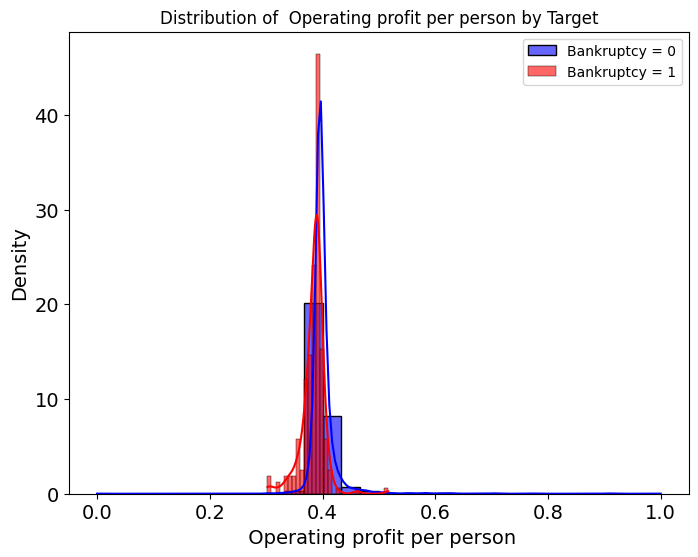

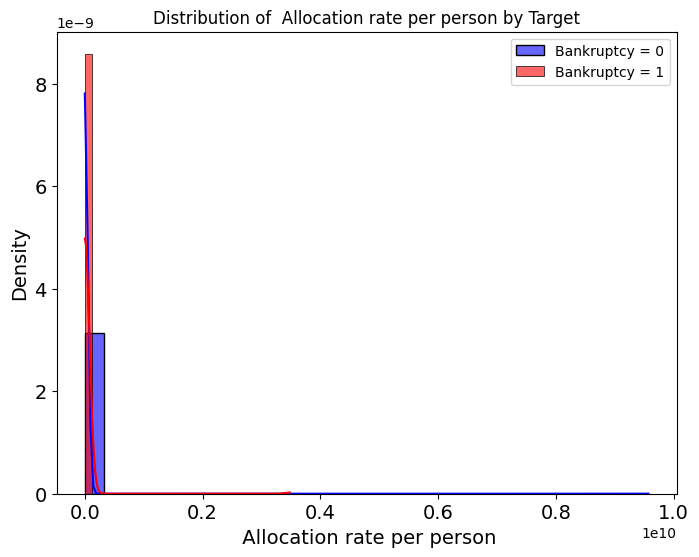

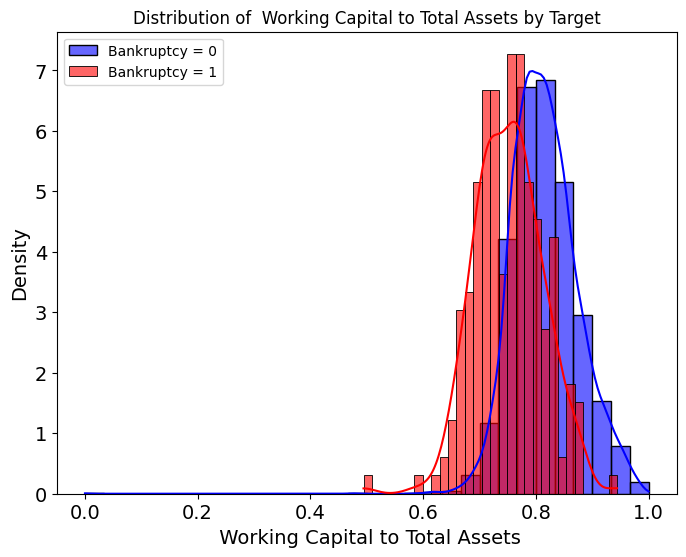

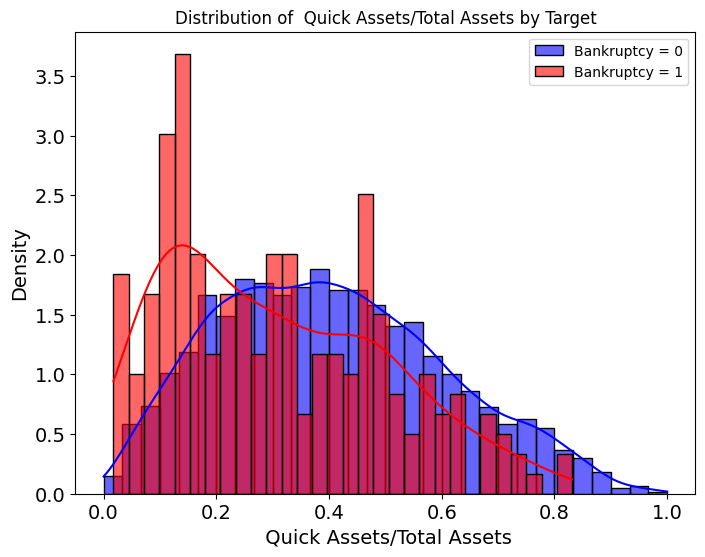

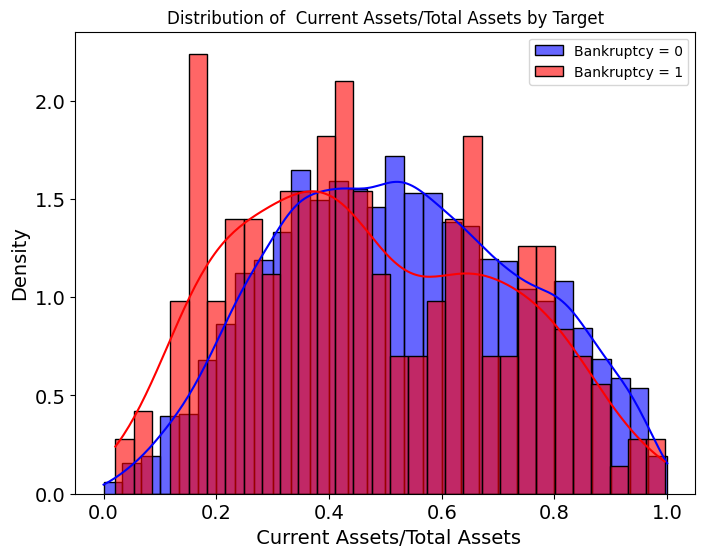

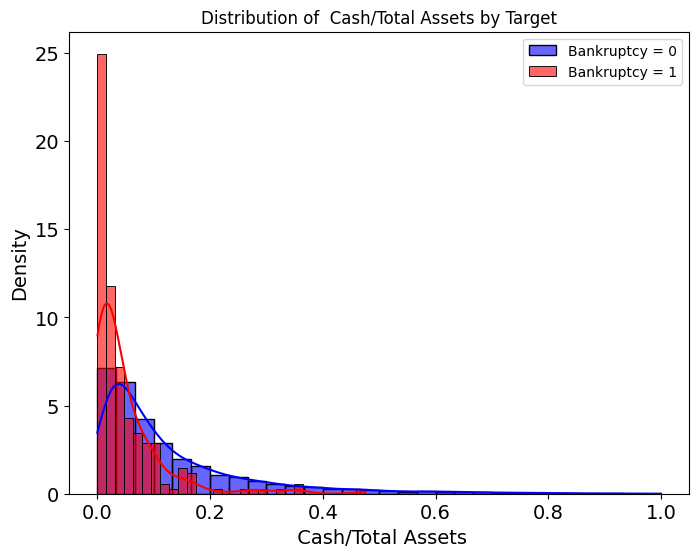

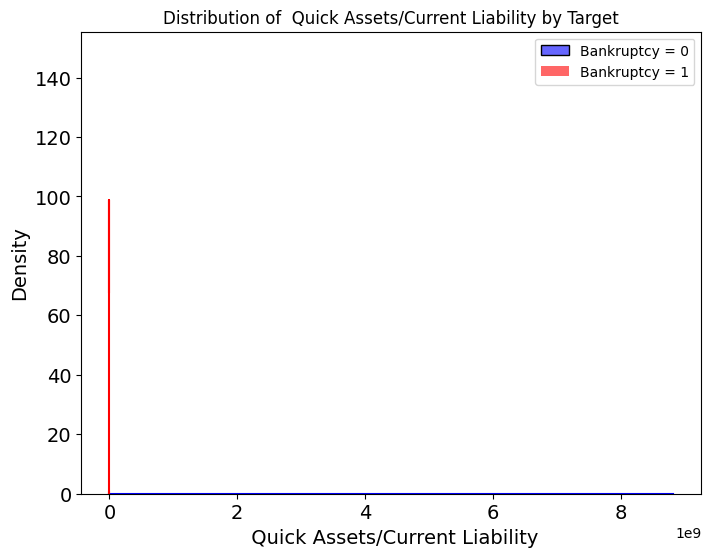

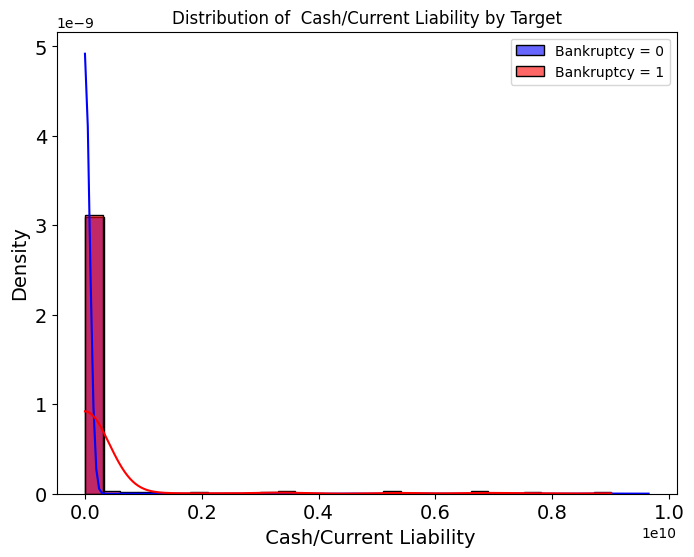

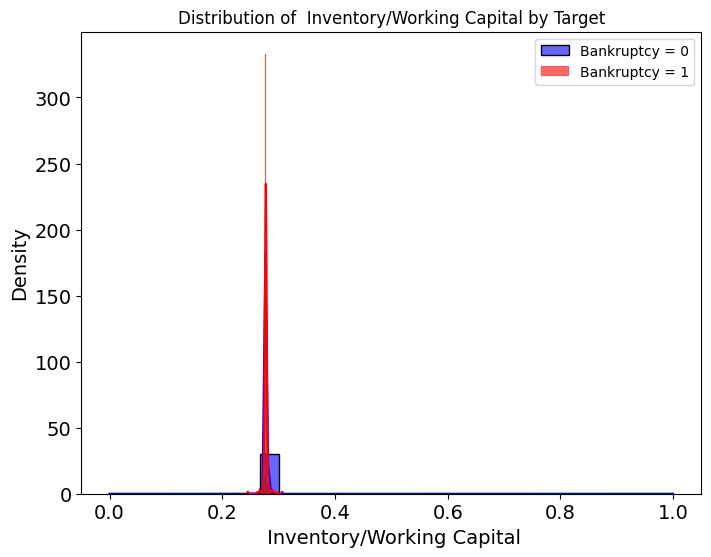

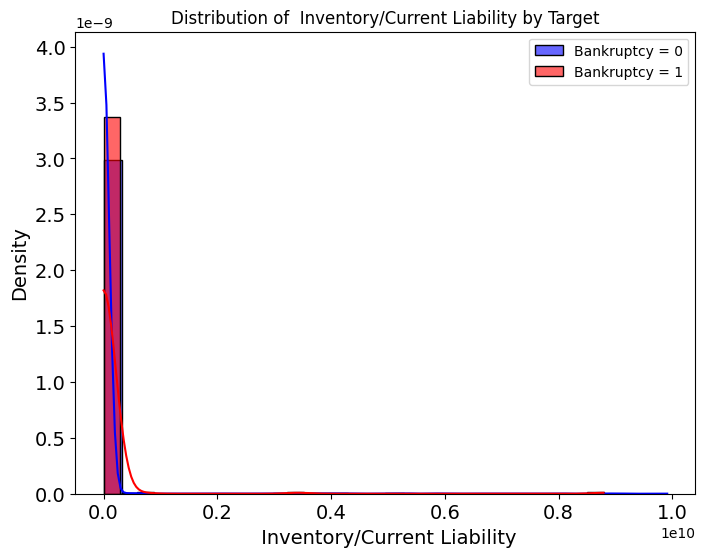

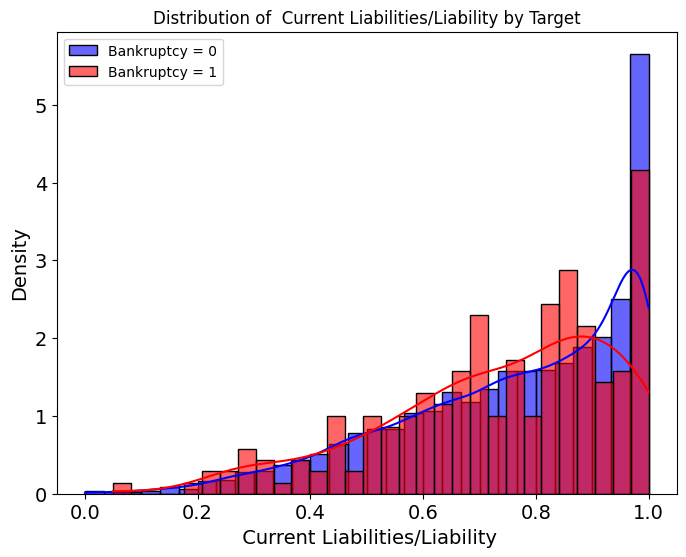

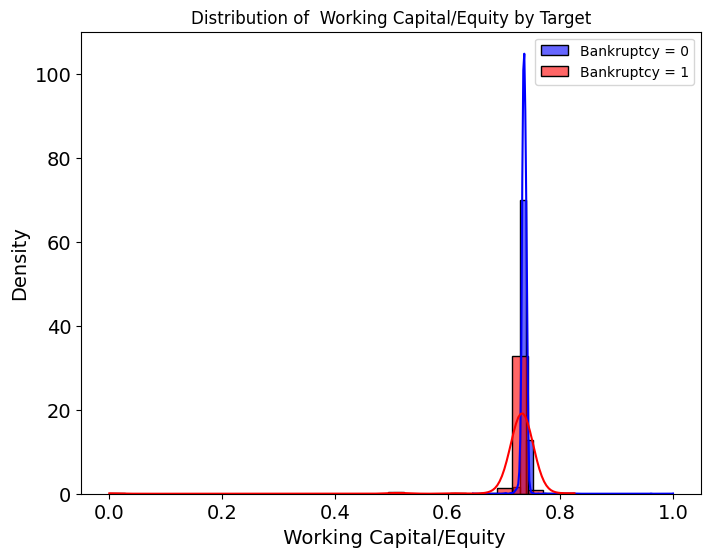

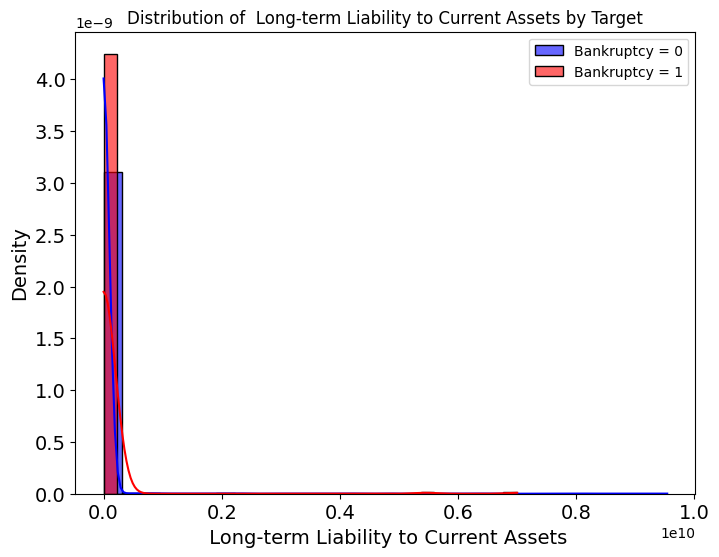

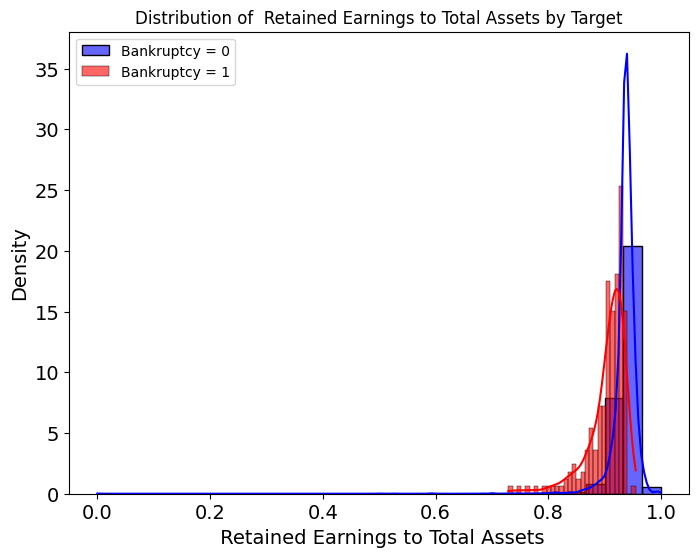

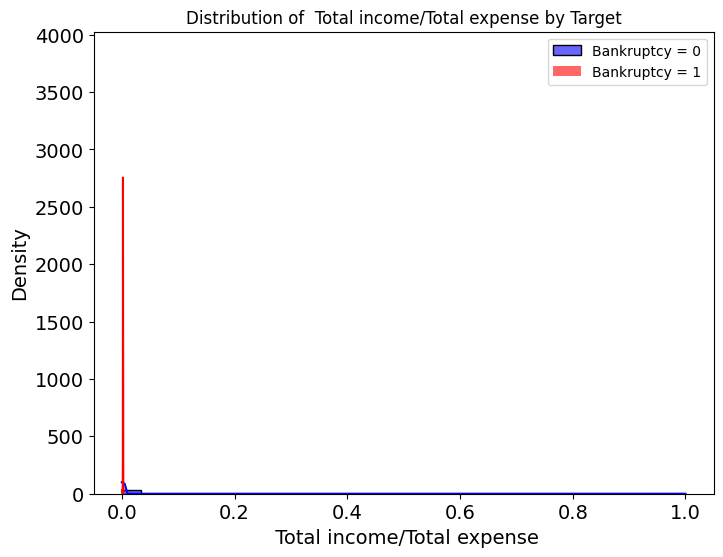

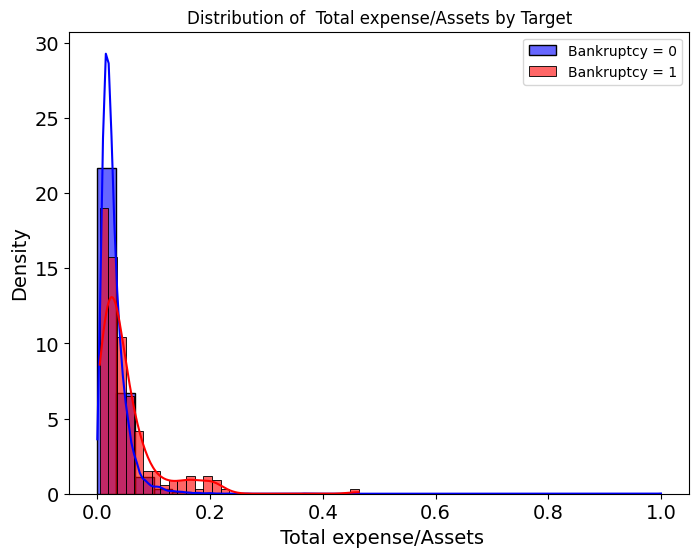

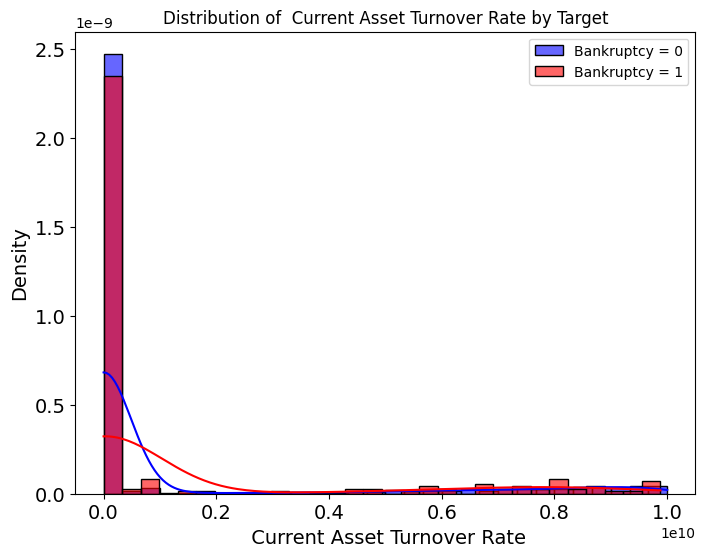

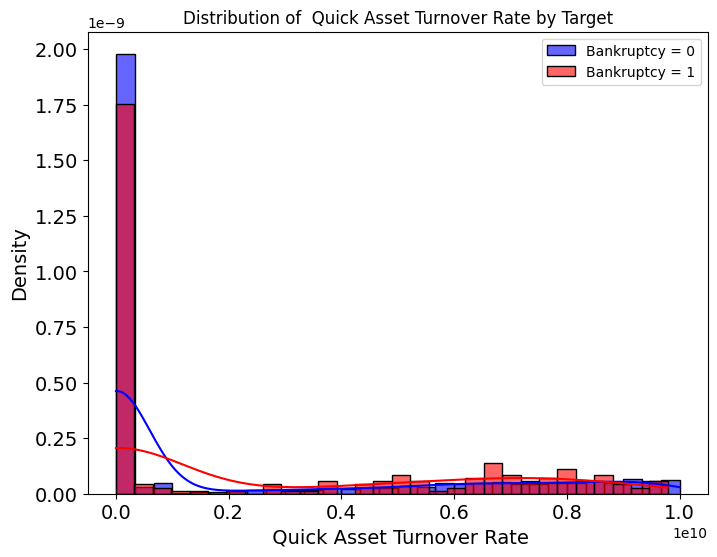

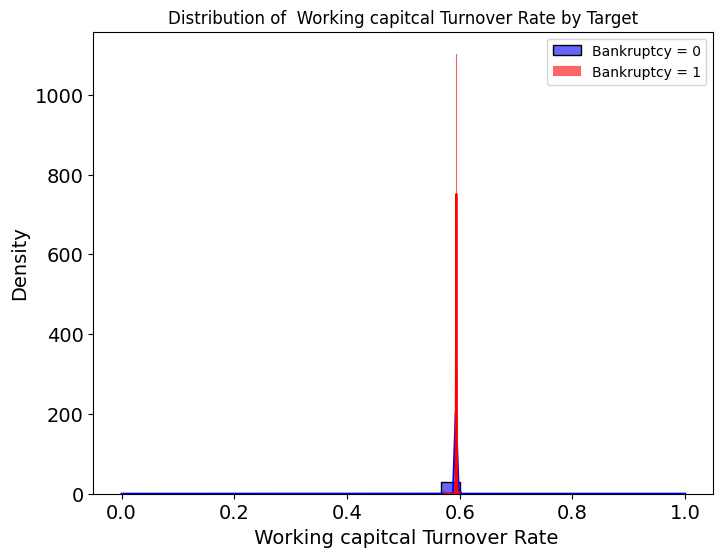

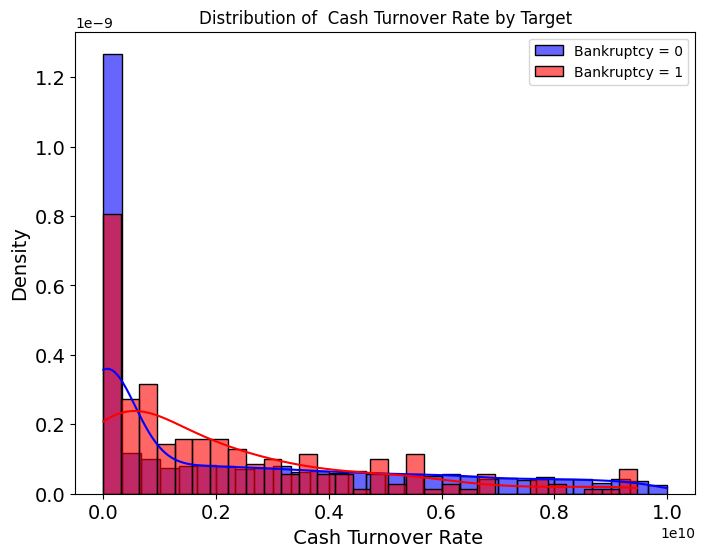

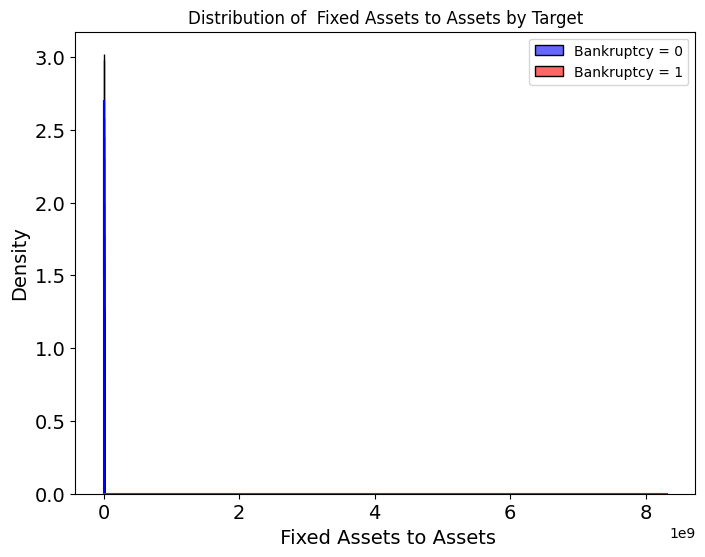

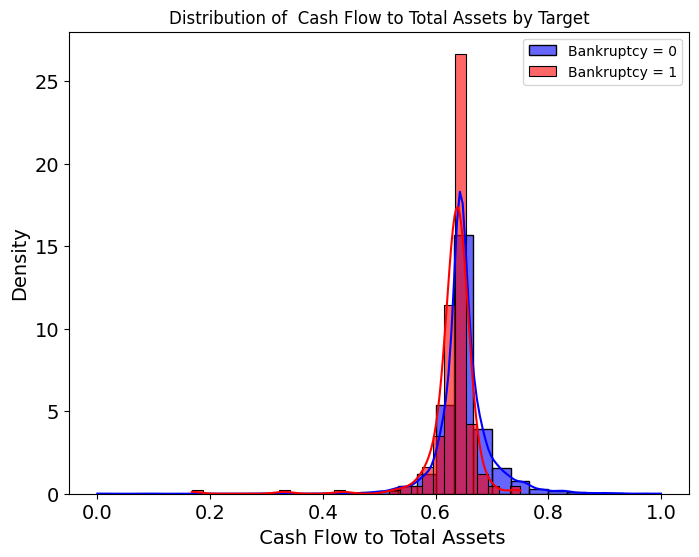

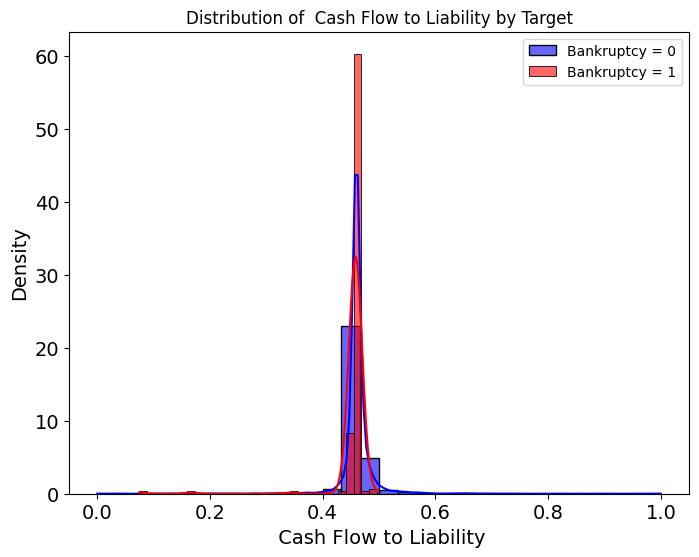

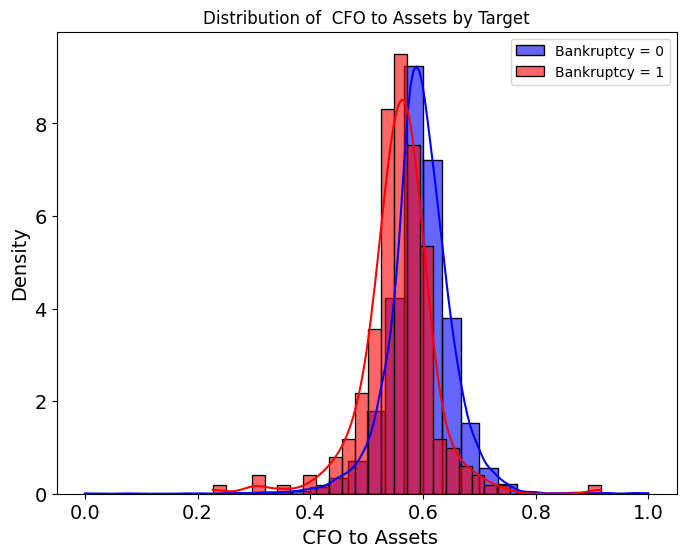

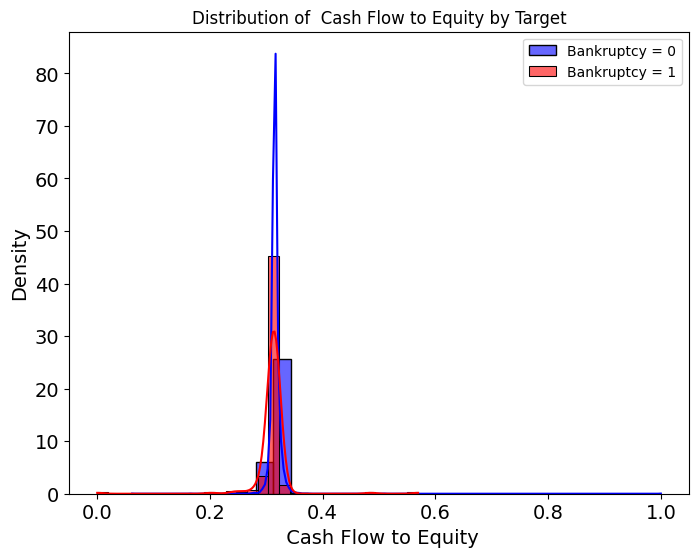

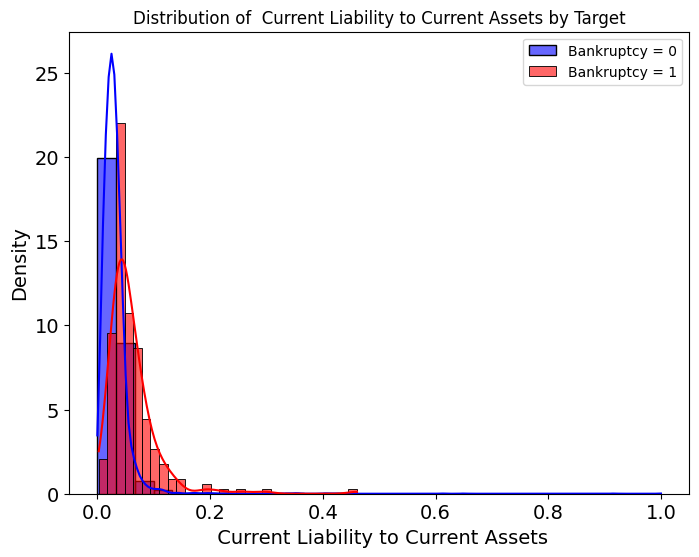

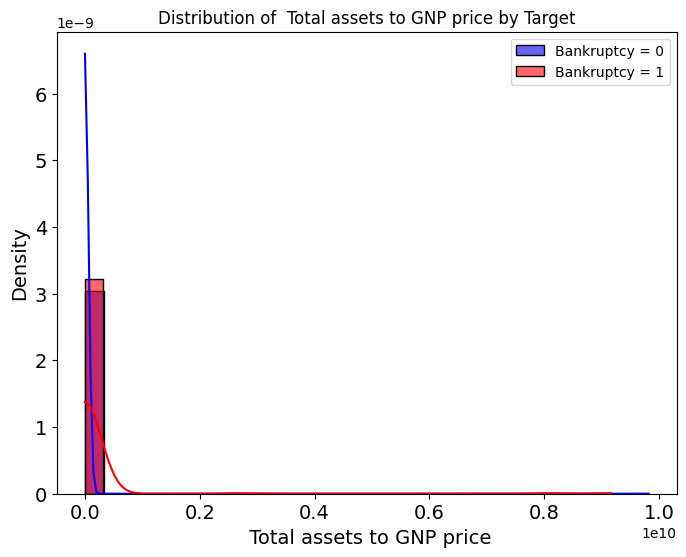

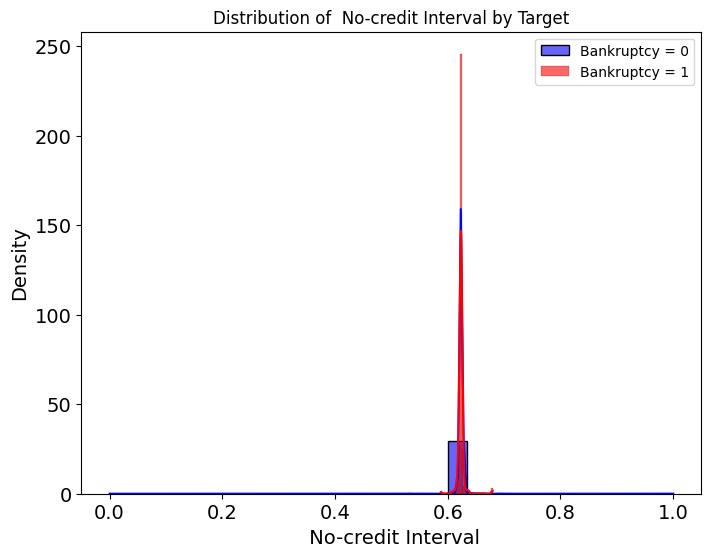

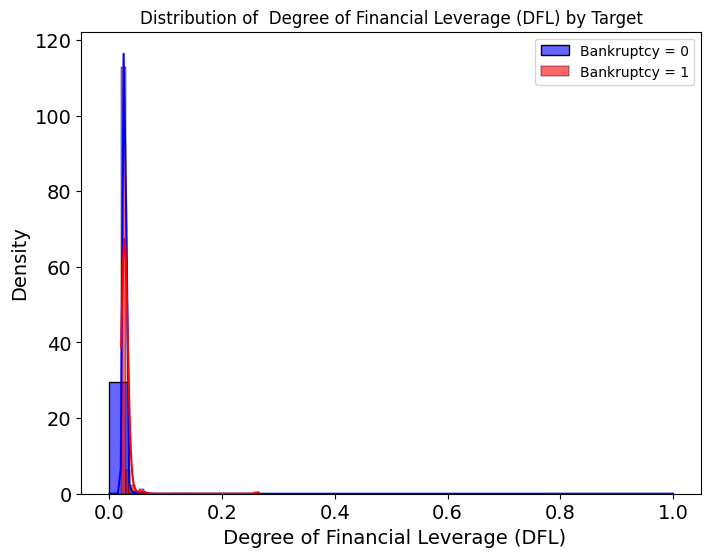

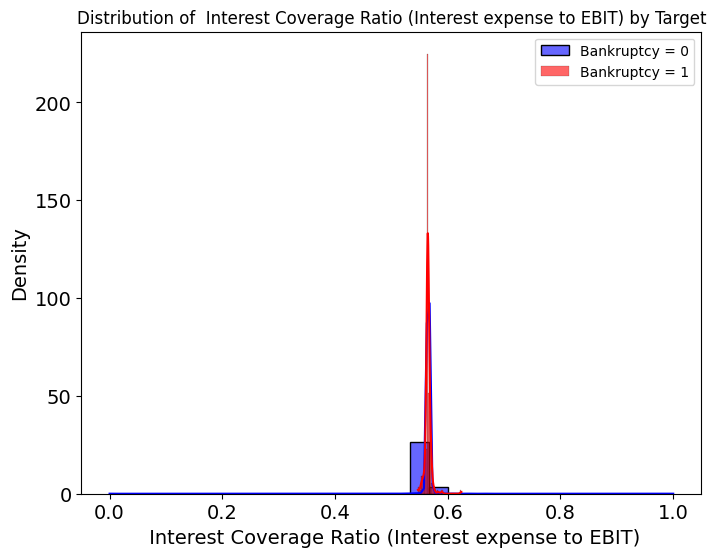

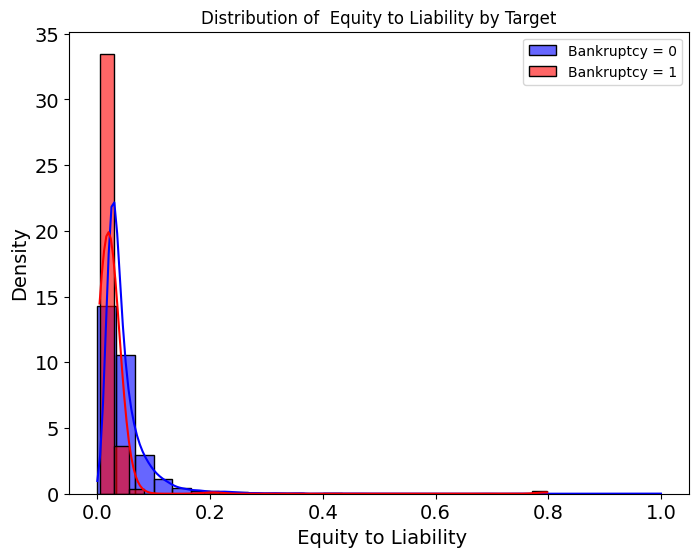

In [46]:
# Plot the distribution of each features that Bankruptcy distribution differ
for col in significant_features:
    plt.figure(figsize=(8, 6))

    # Plot the distribution for target = 0 (in blue)
    sns.histplot(
        df_data_reduced[df_data_reduced[target_column] == 0][col],
        color="blue",
        kde=True,
        label="Bankruptcy = 0",
        bins=30,
        stat="density",
        alpha=0.6,
    )

    # Plot the distribution for target = 1 (in red)
    sns.histplot(
        df_data_reduced[df_data_reduced[target_column] == 1][col],
        color="red",
        kde=True,
        label="Bankruptcy = 1",
        bins=30,
        stat="density",
        alpha=0.6,
    )

    # Set titles and labels
    # Ajouter des labels pour les axes avec une taille augmentée
    plt.title(f"Distribution of {col} by Target")
    plt.xlabel(col, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    # Customize tick label sizes for better readability
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()

    # Show the plot
    plt.show()

### Dataset processing

For the rest of this project, we take the dataset with the features presenting significant features.

In [16]:
X = df_data_reduced[significant_features]
y = df_data_reduced["Bankrupt?"]

In [17]:
y.value_counts()

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

The challenge here is that the perecentage of Bankruptcy is 3.2 % of the dataset. This small value will be challenging because the Bankrupted data might not be enough to train the model to detect bankrupted cpmpanies.

In [18]:
X.shape

(6819, 64)

In [19]:
y.shape

(6819,)

In [20]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#### Oversampling with imblearn

In [21]:
smote = SMOTE()

# Balancing the data
X_train_OS, y_train_OS = smote.fit_resample(X_train, y_train)
X_test_OS, y_test_OS = smote.fit_resample(X_test, y_test)

In [22]:
len(X_train), len(X_train_OS), len(X_test), len(X_test_OS)

(4773, 9238, 2046, 3960)

## Model

##### For the dataset before ovesampling

In [23]:
# Logistic Regression pipeline and hyperparameters
logistic_pipeline = Pipeline(
    [("scaler", StandardScaler()), ("classifier", LogisticRegression(max_iter=1000))]
)

logistic_params = {
    "classifier__C": [0.1, 1, 10],
    "classifier__solver": ["lbfgs", "liblinear"],
}

# Random Forest pipeline and hyperparameters
rf_pipeline = Pipeline(
    [("scaler", StandardScaler()), ("classifier", RandomForestClassifier())]
)

rf_params = {
    "classifier__n_estimators": [50, 100, 200, 1000],
    "classifier__max_depth": [10, 20, None],
}

# Gradient Boosting pipeline and hyperparameters
gb_pipeline = Pipeline(
    [("scaler", StandardScaler()), ("classifier", GradientBoostingClassifier())]
)

gb_params = {
    "classifier__n_estimators": [100, 200, 1000],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__max_depth": [3, 5],
}

# HistGradientBoosting pipeline and hyperparameters
hist_gb_pipeline = Pipeline(
    [("scaler", StandardScaler()), ("classifier", HistGradientBoostingClassifier())]
)

hist_gb_params = {
    "classifier__max_iter": [100, 200, 1000],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__max_depth": [None, 10],
}

# Create a dictionary of models and their hyperparameters
models = {
    "Logistic Regression": (logistic_pipeline, logistic_params),
    "Random Forest": (rf_pipeline, rf_params),
    "Gradient Boosting": (gb_pipeline, gb_params),
    "HistGradient Boosting": (hist_gb_pipeline, hist_gb_params),
}

# Loop through the models, apply GridSearchCV, and evaluate
results = []

for model_name, (pipeline, params) in tqdm(models.items()):
    # Initialize GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        pipeline, param_grid=params, cv=5, n_jobs=-1, scoring="f1_macro"
    )

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Evaluate on test set
    y_pred = best_model.predict(X_test)

    # Store the results
    # print(f"\nResults for {model_name}:")
    # print(f"Best parameters: {grid_search.best_params_}")
    # print(classification_report(y_test, y_pred))
    avg_precision = classification_report(y_test, y_pred)[237:241]
    avg_recall = classification_report(y_test, y_pred)[247:251]
    # Append accuracy score to results
    results.append(
        {
            "Model": model_name,
            "Best Params": grid_search.best_params_,
            "Precision": avg_precision,
            "Recall": avg_recall,
            "F1 score": grid_search.score(X_test, y_test),
        }
    )

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
results_df

100%|██████████| 4/4 [09:03<00:00, 135.84s/it]


Model Performance Comparison:


,Model,Best Params,Precision,Recall,F1 score
0,Logistic Regression,"{'classifier__C': 10, 'classifier__solver': 'l...",0.67,0.58,0.605324
1,Random Forest,"{'classifier__max_depth': 20, 'classifier__n_e...",0.78,0.58,0.621551
2,Gradient Boosting,"{'classifier__learning_rate': 0.1, 'classifier...",0.67,0.59,0.617927
3,HistGradient Boosting,"{'classifier__learning_rate': 0.01, 'classifie...",0.81,0.63,0.684236


In our case, the dataset is imbalanced, therefore i used the F1 score. However, the scores are not very satisfying.

For this reason, i will try some oversampling of the Bankruptcy dataset in order to balance the dataset and get more Bankrupted cases in order to train the model to detect Bankrupted cases.

##### For the oversampled dataset

In [24]:
# Logistic Regression pipeline and hyperparameters
logistic_pipeline = Pipeline(
    [("scaler", StandardScaler()), ("classifier", LogisticRegression(max_iter=1000))]
)

logistic_params = {
    "classifier__C": [0.1, 1, 10],
    "classifier__solver": ["lbfgs", "liblinear"],
}

# Random Forest pipeline and hyperparameters
rf_pipeline = Pipeline(
    [("scaler", StandardScaler()), ("classifier", RandomForestClassifier())]
)

rf_params = {
    "classifier__n_estimators": [50, 100, 200, 1000],
    "classifier__max_depth": [10, 20, None],
}

# Gradient Boosting pipeline and hyperparameters
gb_pipeline = Pipeline(
    [("scaler", StandardScaler()), ("classifier", GradientBoostingClassifier())]
)

gb_params = {
    "classifier__n_estimators": [100, 200, 1000],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__max_depth": [3, 5],
}

# HistGradientBoosting pipeline and hyperparameters
hist_gb_pipeline = Pipeline(
    [("scaler", StandardScaler()), ("classifier", HistGradientBoostingClassifier())]
)

hist_gb_params = {
    "classifier__max_iter": [100, 200, 1000],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__max_depth": [None, 10],
}

# Create a dictionary of models and their hyperparameters
models = {
    "Logistic Regression": (logistic_pipeline, logistic_params),
    "Random Forest": (rf_pipeline, rf_params),
    "Gradient Boosting": (gb_pipeline, gb_params),
    "HistGradient Boosting": (hist_gb_pipeline, hist_gb_params),
}

# Loop through the models, apply GridSearchCV, and evaluate
results_OS = []

for model_name, (pipeline, params) in tqdm(models.items()):
    # Initialize GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        pipeline, param_grid=params, cv=5, n_jobs=-1, scoring="f1_macro"
    )

    # Fit the model
    grid_search.fit(X_train_OS, y_train_OS)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Evaluate on test set
    y_pred_OS = best_model.predict(X_test_OS)

    # Store the results
    # print(f"\nResults for {model_name}:")
    # print(f"Best parameters: {grid_search.best_params_}")
    # print(classification_report(y_test, y_pred))
    avg_precision = classification_report(y_test_OS, y_pred_OS)[237:241]
    avg_recall = classification_report(y_test_OS, y_pred_OS)[247:251]
    # Append accuracy score to results
    results_OS.append(
        {
            "Model": model_name,
            "Best Params": grid_search.best_params_,
            "Precision": avg_precision,
            "Recall": avg_recall,
            "F1 score": grid_search.score(X_test_OS, y_test_OS),
        }
    )

# Convert results to a DataFrame for easy comparison
results_df_OS = pd.DataFrame(results_OS)
print("\nModel Performance Comparison:")
results_df_OS

100%|██████████| 4/4 [22:22<00:00, 335.69s/it]


Model Performance Comparison:


,Model,Best Params,Precision,Recall,F1 score
0,Logistic Regression,"{'classifier__C': 1, 'classifier__solver': 'lb...",0.84,0.84,0.835293
1,Random Forest,"{'classifier__max_depth': None, 'classifier__n...",0.86,0.83,0.831672
2,Gradient Boosting,"{'classifier__learning_rate': 0.1, 'classifier...",0.87,0.84,0.834965
3,HistGradient Boosting,"{'classifier__learning_rate': 0.1, 'classifier...",0.89,0.87,0.867867


#### Feature importance
For the original dataset

In [25]:
# Best params
rf_params = results_df_OS["Best Params"][results_df_OS["Model"] == "Random Forest"]

# Random Forest model with the best parameters, the results are in the DataFrame result_df_OS
best_rf_model = RandomForestClassifier(
    n_estimators=rf_params[1]["classifier__n_estimators"],  # specify the best value
    max_depth=rf_params[1]["classifier__max_depth"],  # specify the best value
    random_state=42,
)

# Fit the model to the training data
best_rf_model.fit(X_train, y_train)

# Extract feature importances
feature_importances_rf = best_rf_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame(
    {
        "Feature": X_train.columns,  # Make sure X_train has named columns
        "Importance": feature_importances_rf,
    }
).sort_values(by="Importance", ascending=False)

print("\nRandom Forest Feature Importances:")
feature_importances_df.head()


Random Forest Feature Importances:


,Feature,Importance
17,Net Value Growth Rate,0.047938
9,Persistent EPS in the Last Four Seasons,0.042305
26,Borrowing dependency,0.035350
8,Net Value Per Share (B),0.030176
0,ROA(C) before interest and depreciation befor...,0.026102


For the Oversampled Dataset

In [26]:
# Best params
rf_params_OS = results_df_OS["Best Params"][results_df_OS["Model"] == "Random Forest"]

# Random Forest model with the best parameters, the results are in the DataFrame result_df_OS
best_rf_model_OS = RandomForestClassifier(
    n_estimators=rf_params_OS[1]["classifier__n_estimators"],  # specify the best value
    max_depth=rf_params_OS[1]["classifier__max_depth"],  # specify the best value
    random_state=42,
)

# Fit the model to the training data
best_rf_model_OS.fit(X_train_OS, y_train_OS)

# Extract feature importances
feature_importances_rf_OS = best_rf_model_OS.feature_importances_

# Create a DataFrame to display feature importances
feature_importances_df_OS = pd.DataFrame(
    {
        "Feature": X_train_OS.columns,  # Make sure X_train has named columns
        "Importance": feature_importances_rf_OS,
    }
).sort_values(by="Importance", ascending=False)

print("\nRandom Forest Feature Importances:")
feature_importances_df_OS.head()


Random Forest Feature Importances:


,Feature,Importance
9,Persistent EPS in the Last Four Seasons,0.093487
23,Total debt/Total net worth,0.080125
26,Borrowing dependency,0.076961
46,Retained Earnings to Total Assets,0.076811
0,ROA(C) before interest and depreciation befor...,0.056306


## Annexe
#### Model in one Class
The goal of this section is to apply what we learned in class, to do Classes, therefore in this section i create a class that we can use to do the whole previous work.

In [ ]:
class BankruptcyModel:
    def __init__(self, data, target_column="Bankrupt?"):
        self.data = data
        self.target_column = target_column
        self.significant_features = []
        self.similar_dist_features = []
        self.models = None
        self.results = None

    def preprocessing(self, correlation_threshold=0.8, ks_p_value=0.01):
        # Remove highly correlated features
        corr_matrix = self.data.corr().abs()
        upper_tri = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        high_corr_pairs = corr_matrix.where(upper_tri).stack().reset_index()
        high_corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]
        high_corr_pairs_filtered = high_corr_pairs[
            high_corr_pairs["Correlation"] > correlation_threshold
        ]

        # Drop one feature of each highly correlated pair
        self.data = self.data.drop(
            high_corr_pairs_filtered["Feature 2"].unique(), axis=1
        )

        # Droped Features
        print(
            "We have",
            len(high_corr_pairs_filtered["Feature 2"].unique()),
            "highly correlated columns as show in the correlation matrix.\nThese columns could lead to an overfitting in the model prediction this is why it is better to drop these columns from the dataset.",
        )

        # Step 2: Perform the KS test to find significant features
        feature_columns = self.data.drop(columns=[self.target_column]).columns.to_list()
        for col in feature_columns:
            feature_target_0 = self.data[self.data[self.target_column] == 0][col]
            feature_target_1 = self.data[self.data[self.target_column] == 1][col]
            ks_stat, p_value = ks_2samp(feature_target_0, feature_target_1)
            if p_value < ks_p_value:
                self.significant_features.append(col)

        # Store similar distribution features
        self.similar_dist_features = [
            col for col in feature_columns if col not in self.significant_features
        ]
        print(
            f"There is {len(self.significant_features)} significant features based on KS test."
        )

    def split_train_test(self, test_size=0.3, random_state=42):
        # Separate features and target
        X = self.data.drop(self.target_column, axis=1)
        y = self.data[self.target_column]

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state
        )
        return X_train, X_test, y_train, y_test

    def apply_smote(self, X_train, y_train, random_state=42):
        # Apply SMOTE to balance the training data
        smote = SMOTE(random_state=random_state)
        X_train_OS, y_train_OS = smote.fit_resample(X_train, y_train)
        return X_train_OS, y_train_OS

    def train_models(self, X_train, X_test, y_train, y_test):
        # Define models and parameters
        self.models = {
            "Logistic Regression": (
                Pipeline(
                    [
                        ("scaler", StandardScaler()),
                        ("classifier", LogisticRegression(max_iter=1000)),
                    ]
                ),
                {
                    "classifier__C": [0.1, 1, 10],
                    "classifier__solver": ["lbfgs", "liblinear"],
                },
            ),
            "Random Forest": (
                Pipeline(
                    [
                        ("scaler", StandardScaler()),
                        ("classifier", RandomForestClassifier()),
                    ]
                ),
                {
                    "classifier__n_estimators": [50, 100, 200, 1000],
                    "classifier__max_depth": [10, 20, None],
                },
            ),
            "Gradient Boosting": (
                Pipeline(
                    [
                        ("scaler", StandardScaler()),
                        ("classifier", GradientBoostingClassifier()),
                    ]
                ),
                {
                    "classifier__n_estimators": [100, 200, 1000],
                    "classifier__learning_rate": [0.01, 0.1],
                    "classifier__max_depth": [3, 5],
                },
            ),
            "HistGradient Boosting": (
                Pipeline(
                    [
                        ("scaler", StandardScaler()),
                        ("classifier", HistGradientBoostingClassifier()),
                    ]
                ),
                {
                    "classifier__max_iter": [100, 200, 1000],
                    "classifier__learning_rate": [0.01, 0.1],
                    "classifier__max_depth": [None, 10],
                },
            ),
        }

        # Store results for each model
        self.results = []

        # Training and evaluation
        for model_name, (pipeline, params) in tqdm(self.models.items()):
            grid_search = GridSearchCV(
                pipeline, param_grid=params, cv=5, n_jobs=-1, scoring="f1_macro"
            )
            grid_search.fit(X_train, y_train)

            # Get best model and evaluate on test set
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)

            # Calculate metrics
            report = classification_report(y_test, y_pred, output_dict=True)
            avg_precision = report["weighted avg"]["precision"]
            avg_recall = report["weighted avg"]["recall"]
            f1_score = report["weighted avg"]["f1-score"]

            # Append results
            self.results.append(
                {
                    "Model": model_name,
                    "Best Params": grid_search.best_params_,
                    "Precision": avg_precision,
                    "Recall": avg_recall,
                    "F1 score": f1_score,
                }
            )

        # Convert results to DataFrame for better readability
        results_df = pd.DataFrame(self.results)
        print("Results are in this DataFrame")
        return results_df


# Example usage:
bankruptcy_model = BankruptcyModel(df_data)
bankruptcy_model.preprocessing()
X_train, X_test, y_train, y_test = bankruptcy_model.split_train_test()
X_train_OS, y_train_OS = bankruptcy_model.apply_smote(X_train, y_train)
X_test_OS, y_test_OS = bankruptcy_model.apply_smote(X_test, y_test)
results_df = bankruptcy_model.train_models(X_train_OS, X_test_OS, y_train_OS, y_test_OS)

We have 25 highly correlated columns as show in the correlation matrix.
These columns could lead to an overfitting in the model prediction this is why it is better to drop these columns from the dataset.
There is 64 significant features based on KS test.


100%|██████████| 4/4 [23:21<00:00, 350.32s/it]

Results are in this DataFrame


In [ ]:
results_df

,Model,Best Params,Precision,Recall,F1 score
0,Logistic Regression,"{'classifier__C': 1, 'classifier__solver': 'li...",0.858928,0.856313,0.856051
1,Random Forest,"{'classifier__max_depth': None, 'classifier__n...",0.858906,0.830808,0.827431
2,Gradient Boosting,"{'classifier__learning_rate': 0.1, 'classifier...",0.872356,0.842677,0.839478
3,HistGradient Boosting,"{'classifier__learning_rate': 0.1, 'classifier...",0.897746,0.878283,0.876775


#### Example of a dataset where i can use OneHotEncoding, or LabelEncoder


#### Dataset

#### Categorical data

In [ ]:
# Sample DataFrame
data = {"Color": ["Red", "Blue", "Green", "Green", "Red"]}
df = pd.DataFrame(data)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the 'Color' column
onehot_encoded = encoder.fit(df[["Color"]])
onehot_encoded = onehot_encoded.transform(df[["Color"]])

# Create a DataFrame with the one-hot encoded columns
onehot_df = pd.DataFrame(
    onehot_encoded, columns=encoder.get_feature_names_out(["Color"]).T
)

# Concatenate the original DataFrame with the new one-hot encoded DataFrame
df = pd.concat([df, onehot_df], axis=1)
df

,Color,Color_Blue,Color_Green,Color_Red
0,Red,0.0,0.0,1.0
1,Blue,1.0,0.0,0.0
2,Green,0.0,1.0,0.0
3,Green,0.0,1.0,0.0
4,Red,0.0,0.0,1.0
